# Regularisation Techniques

This notebook explores regularisation methods to prevent overfitting in neural networks. I implement L2 regularisation (weight decay), early stopping, and L1 regularisation (LASSO), visualizing how each affects training.

**Topics covered:**
- L2 regularisation and the bias-variance tradeoff
- Early stopping based on validation loss
- L1 regularisation for sparse weights

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm

## Part 1: L2 Regularisation and Bias-Variance Tradeoff

I'm fitting a polynomial model to noisy data generated from a known function. Without regularisation, high-degree polynomials will overfit. L2 regularisation penalises large weights, which reduces variance at the cost of some bias.

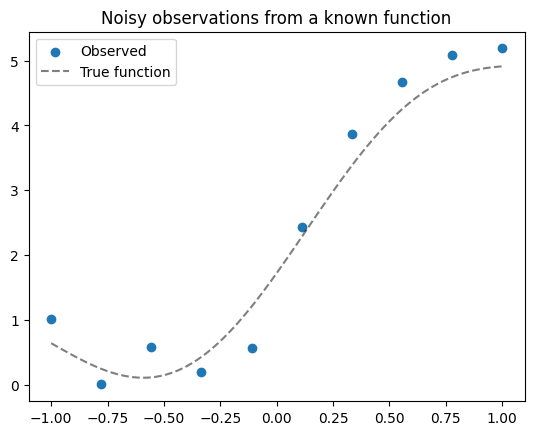

In [21]:
#generating synthetic data from a known function
np.random.seed(69)

X = np.linspace(1, 3, 10)
y_true = lambda x: np.sin(3*x) + 0.5*x**2
y_obs = y_true(X) + np.random.normal(0, 0.4, size=X.shape)

df = pd.DataFrame({'x': X - 2, 'y': y_obs})  #centering x around 0

plt.scatter(df['x'], df['y'], label='Observed')
x_line = np.linspace(-1, 1, 100)
plt.plot(x_line, y_true(x_line + 2), 'k--', alpha=0.5, label='True function')
plt.legend()
plt.title('Noisy observations from a known function')
plt.show()

In [22]:
#polynomial regression model - each feature is a power of x
class PolynomialModel(nn.Module):
    def __init__(self, degree):
        super().__init__()
        self.poly = nn.Linear(degree, 1)
        self.degree = degree

    def forward(self, x):
        #i create polynomial features [x, x^2, x^3, ...]
        x_poly = torch.cat([x**i for i in range(1, self.degree + 1)], dim=1)
        return self.poly(x_poly)

In [23]:
#metrics for bias-variance decomposition
def bias(y_true, y_pred):
    return torch.mean(y_pred - y_true)

def variance(y_true, y_pred):
    return torch.var(y_pred - y_true)

def mse(bias_val, var_val):
    #MSE = bias^2 + variance (the decomposition)
    return bias_val ** 2 + var_val

In [24]:
#this plots the model fit alongside loss and bias-variance curves
def plot_fit_status(model, data, x_lin, y_model, loss_hist, bias_hist, var_hist, mse_hist):
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(2, 3)
    ax_main = fig.add_subplot(gs[:, :-1])
    ax_loss = fig.add_subplot(gs[0, 2])
    ax_bivar = fig.add_subplot(gs[1, 2])

    ax_main.scatter(data['x'], data['value'])
    ax_main.plot(x_lin, y_model, color='blue')
    ax_main.plot(x_lin, y_true(x_lin + 2), color='grey', linestyle='dashed', alpha=0.3)
    ax_main.set_title('Model fit')
    ax_main.set_xlabel('x')
    ax_main.set_ylabel('y')
    ax_main.set_ylim(-0.1, 5.1)
    ax_main.grid(alpha=0.3)

    ax_loss.plot(loss_hist)
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.grid(alpha=0.3)

    ax_bivar.plot(bias_hist, label='Bias')
    ax_bivar.plot(var_hist, label='Variance')
    ax_bivar.plot(mse_hist, label='MSE')
    ax_bivar.set_xlabel('Epoch')
    ax_bivar.legend()
    ax_bivar.grid(alpha=0.3)

    plt.tight_layout()

In [25]:
X_lin = np.linspace(-1, 1, 200)

def train_polynomial(model, X, y, epochs=100, lr=0.05, lambda_l2=0.01, plot_freq=25):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    loss_hist, bias_hist, var_hist, mse_hist = [], [], [], []
    X_np = X.numpy().flatten()

    for epoch in tqdm(range(epochs), desc="Training", leave=False):
        model.train()
        model.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        #L2 regularisation: adds penalty on squared weights
        if lambda_l2 > 0:
            l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters())
            loss = loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())

        #tracking bias-variance
        bias_val = bias(torch.tensor(y_true(X_np + 2)), y_pred.detach()).item()
        var_val = variance(torch.tensor(y_true(X_np + 2)), y_pred.detach()).item()
        bias_hist.append(bias_val)
        var_hist.append(var_val)
        mse_hist.append(mse(bias_val, var_val))

        if epoch % plot_freq == 0 or epoch == epochs - 1:
            with torch.no_grad():
                y_lin = model(torch.tensor(X_lin).float().view(-1, 1)).numpy().flatten()
            plot_fit_status(model, pd.DataFrame({'x': X_np, 'value': y.numpy().flatten()}),
                          X_lin, y_lin, loss_hist, bias_hist, var_hist, mse_hist)
            plt.show()

    return loss_hist, bias_hist, var_hist, mse_hist

Training high-degree polynomial WITH regularisation (lambda=0.01):


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

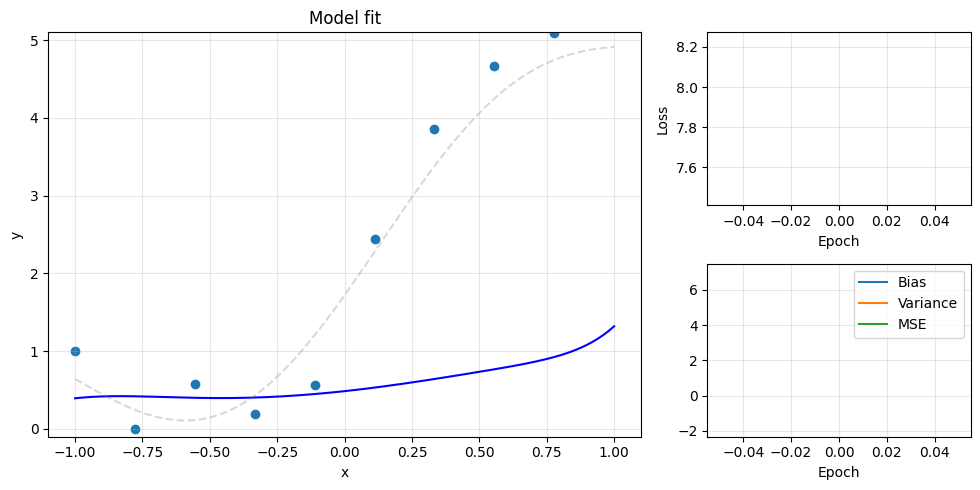

Training:   0%|          | 1/2000 [00:00<12:41,  2.62it/s]

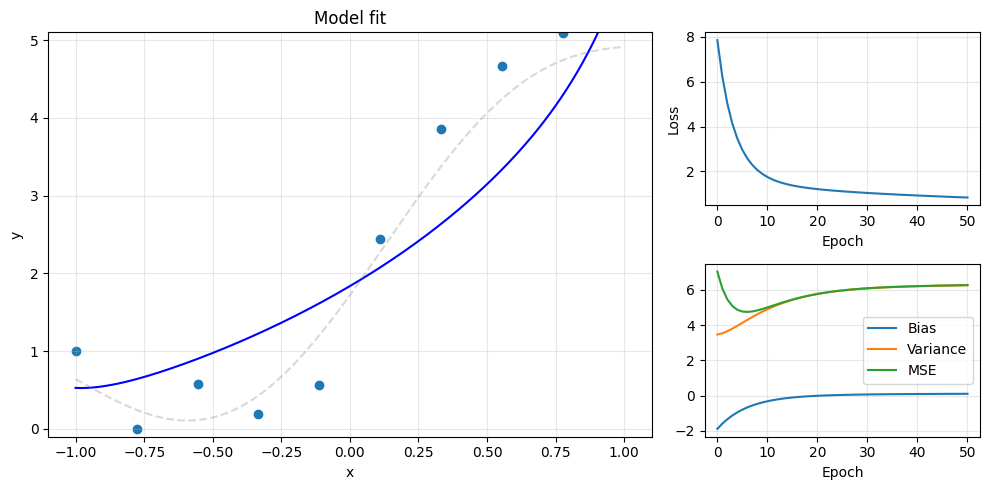

Training:   3%|▎         | 51/2000 [00:00<00:24, 80.65it/s]

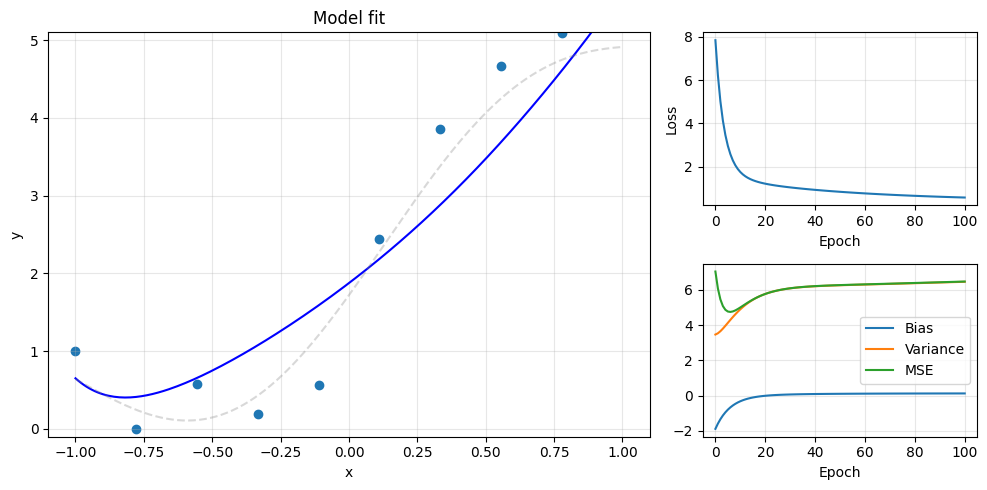

Training:   5%|▌         | 101/2000 [00:01<00:17, 106.39it/s]

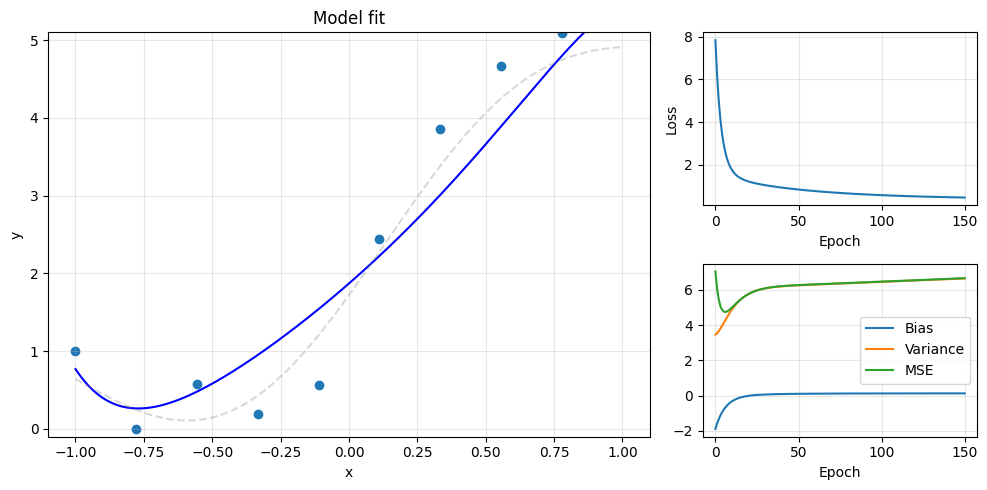

Training:   8%|▊         | 151/2000 [00:01<00:15, 120.51it/s]

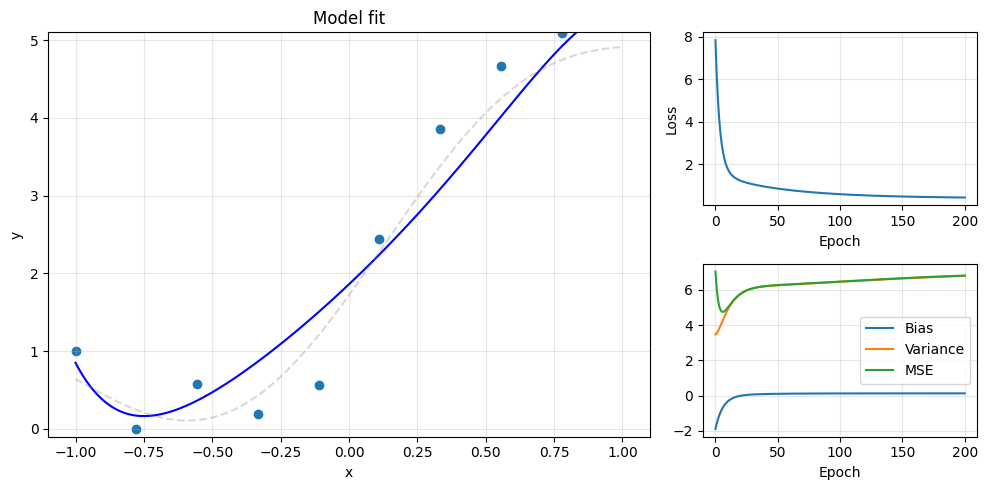

Training:  10%|█         | 201/2000 [00:01<00:13, 129.86it/s]

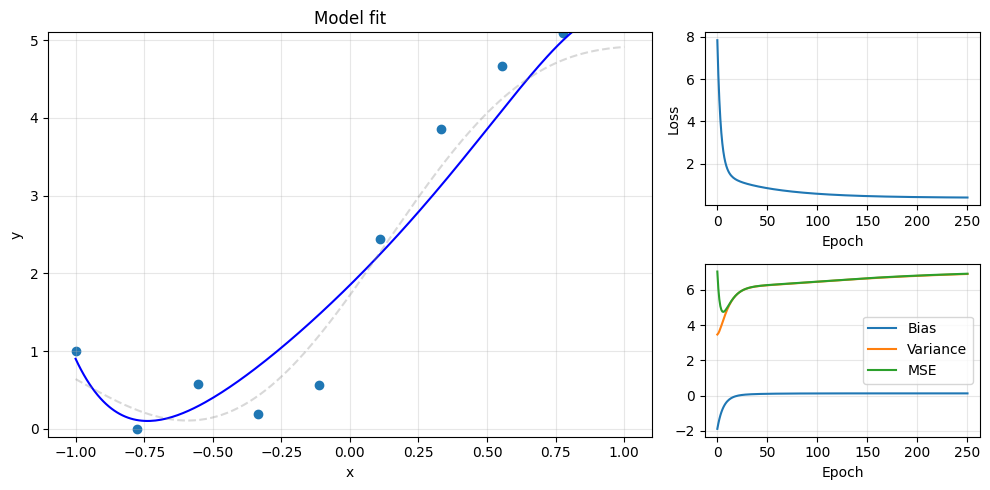

Training:  13%|█▎        | 251/2000 [00:02<00:13, 133.42it/s]

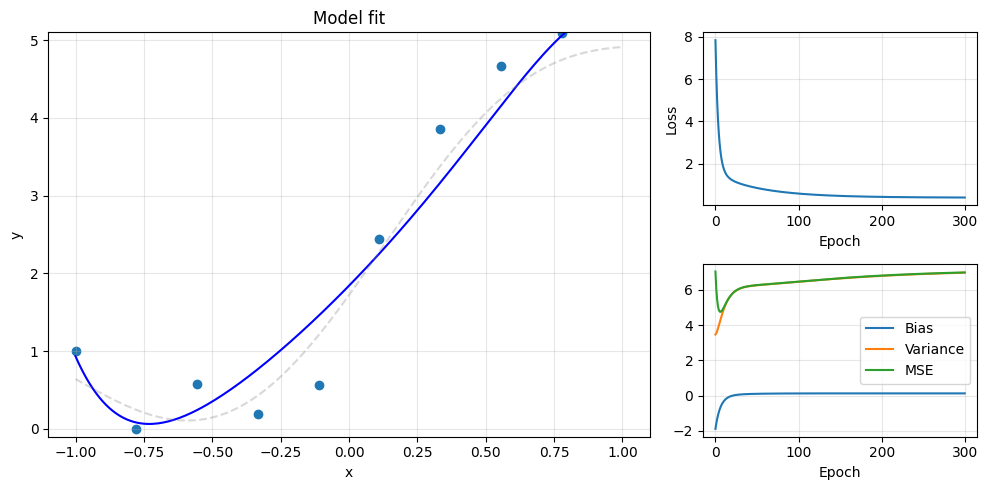

Training:  15%|█▌        | 301/2000 [00:02<00:17, 94.84it/s] 

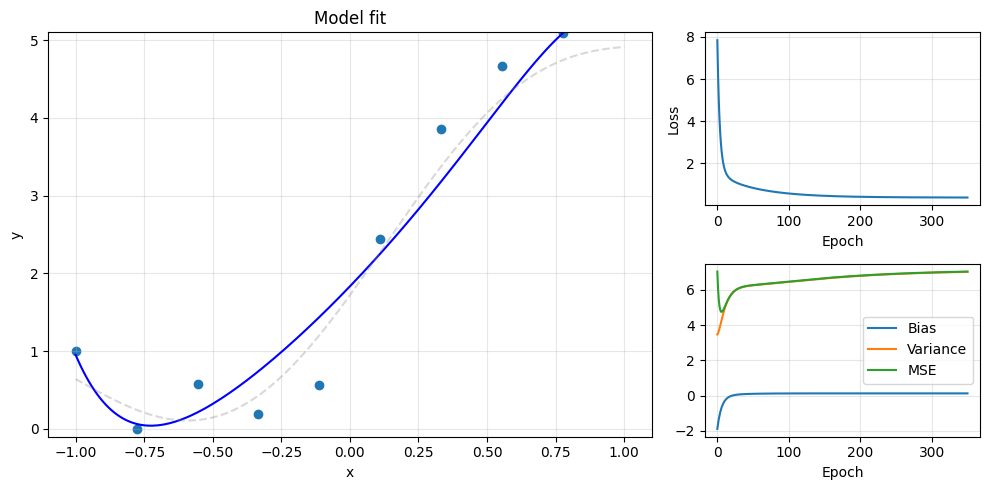

Training:  18%|█▊        | 351/2000 [00:03<00:15, 106.27it/s]

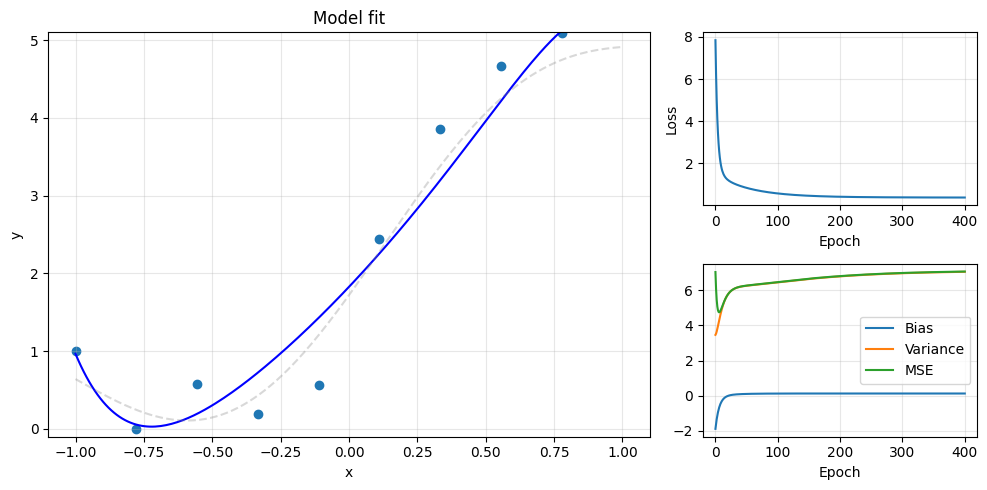

Training:  20%|██        | 401/2000 [00:03<00:14, 113.47it/s]

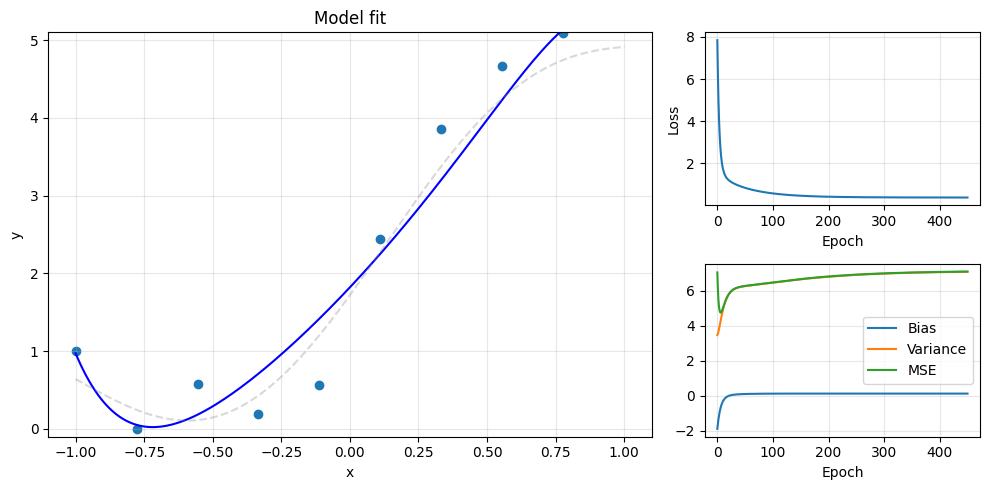

Training:  23%|██▎       | 451/2000 [00:04<00:12, 120.48it/s]

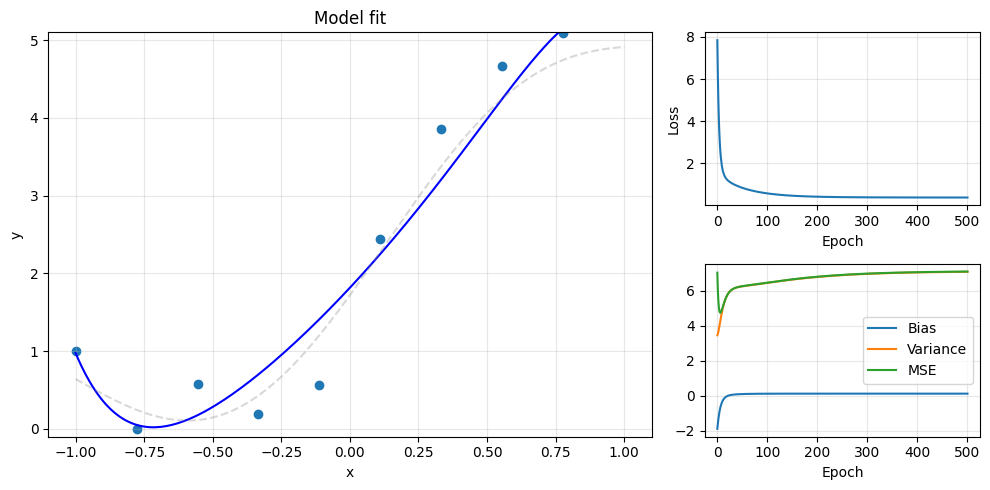

Training:  27%|██▋       | 545/2000 [00:04<00:11, 127.94it/s]

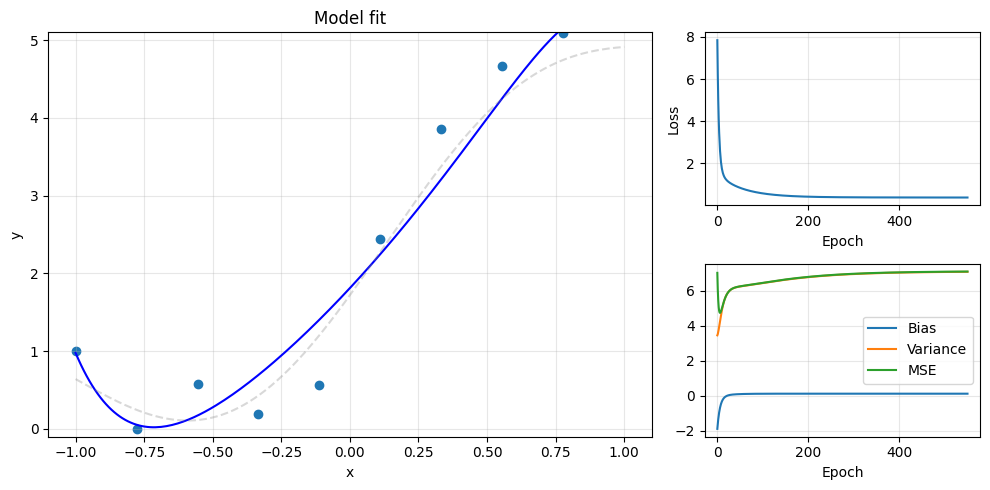

Training:  28%|██▊       | 567/2000 [00:05<00:15, 91.74it/s] 

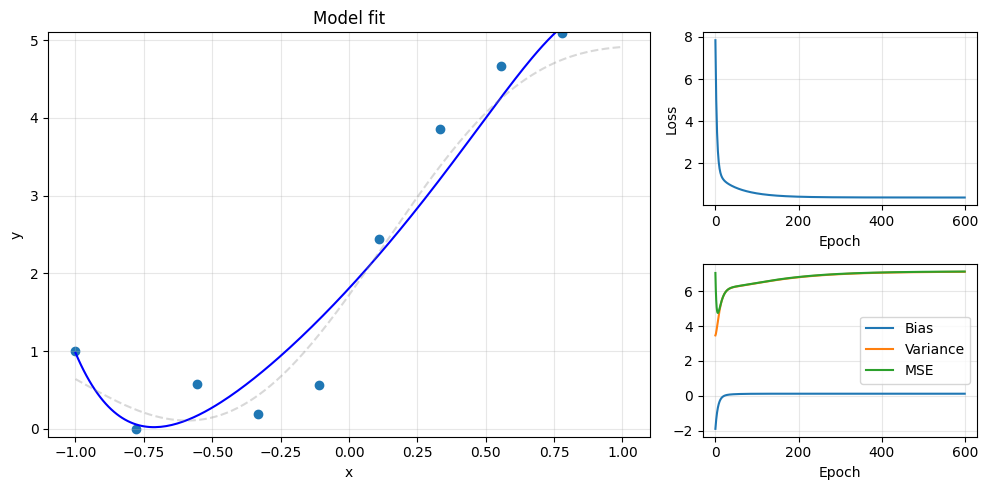

Training:  30%|███       | 601/2000 [00:05<00:16, 87.40it/s]

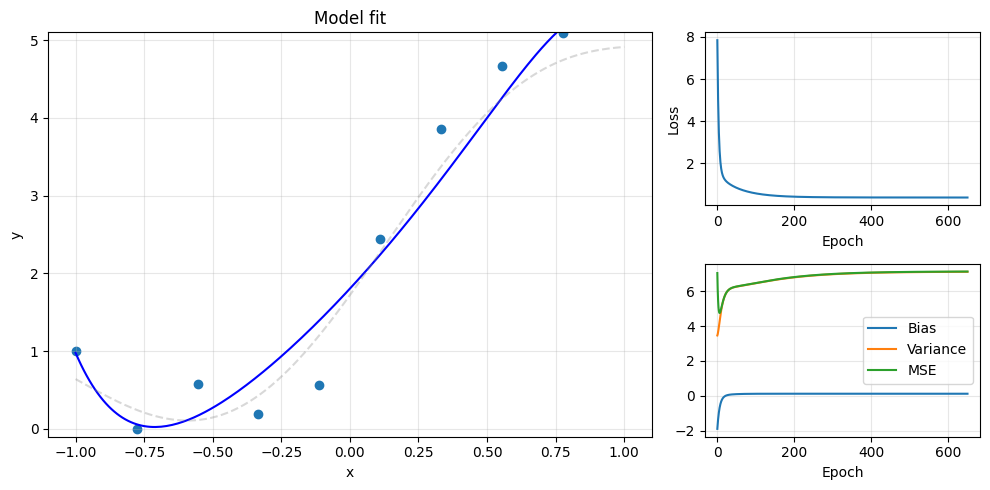

Training:  33%|███▎      | 651/2000 [00:06<00:15, 89.86it/s]

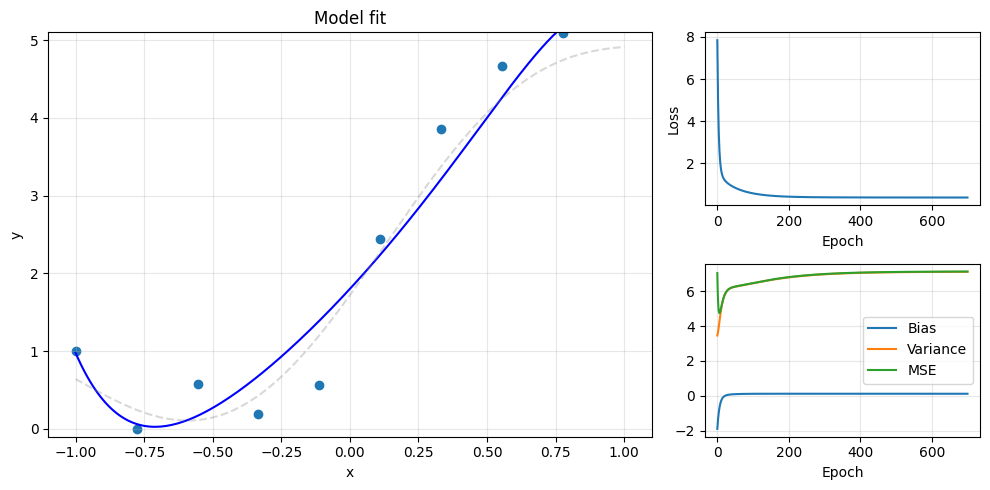

Training:  35%|███▌      | 701/2000 [00:06<00:13, 98.92it/s]

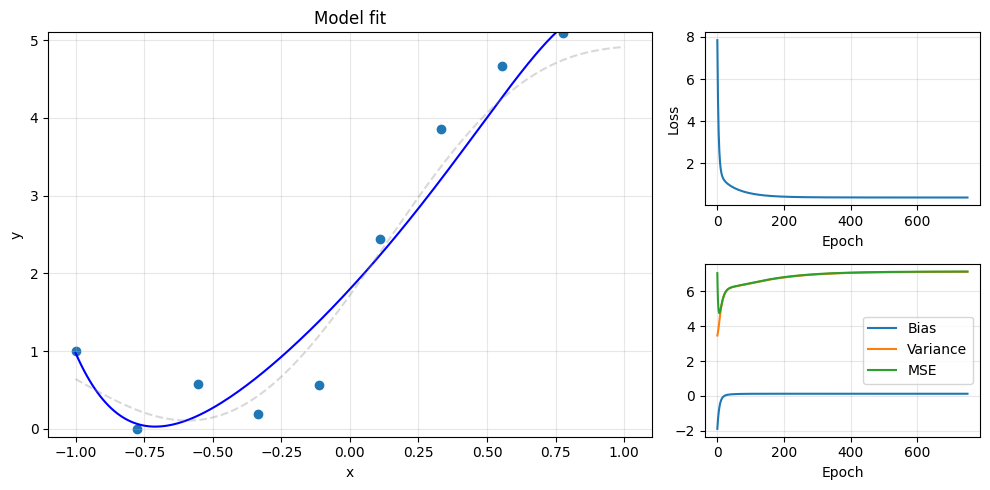

Training:  38%|███▊      | 751/2000 [00:07<00:11, 110.57it/s]

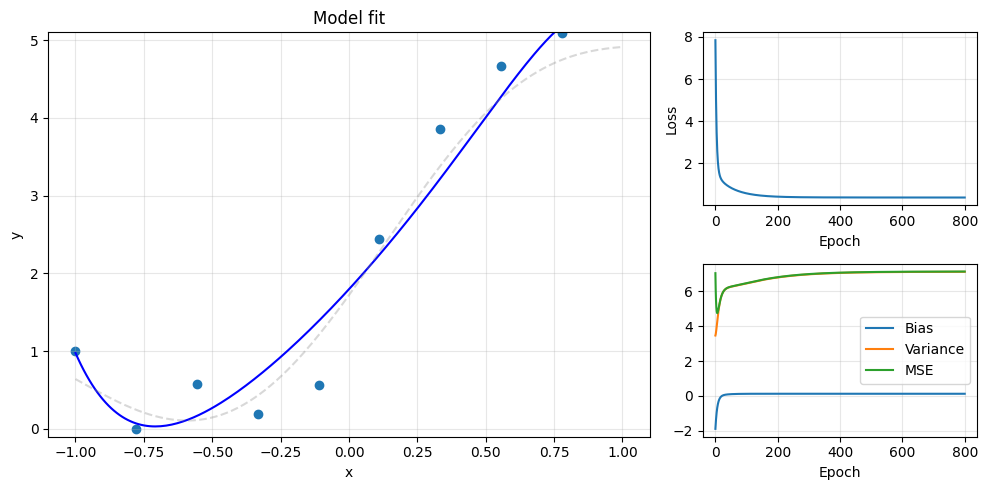

Training:  40%|████      | 801/2000 [00:07<00:13, 88.00it/s] 

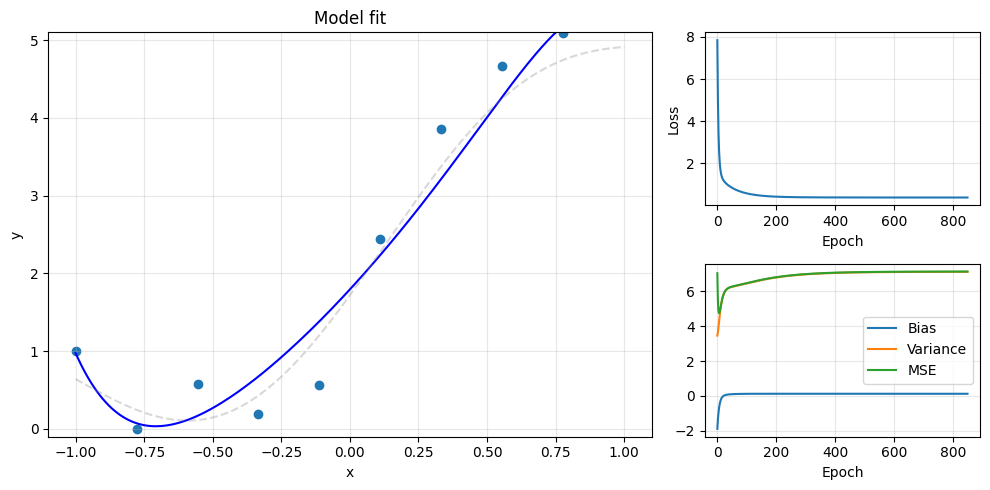

Training:  43%|████▎     | 851/2000 [00:08<00:11, 102.10it/s]

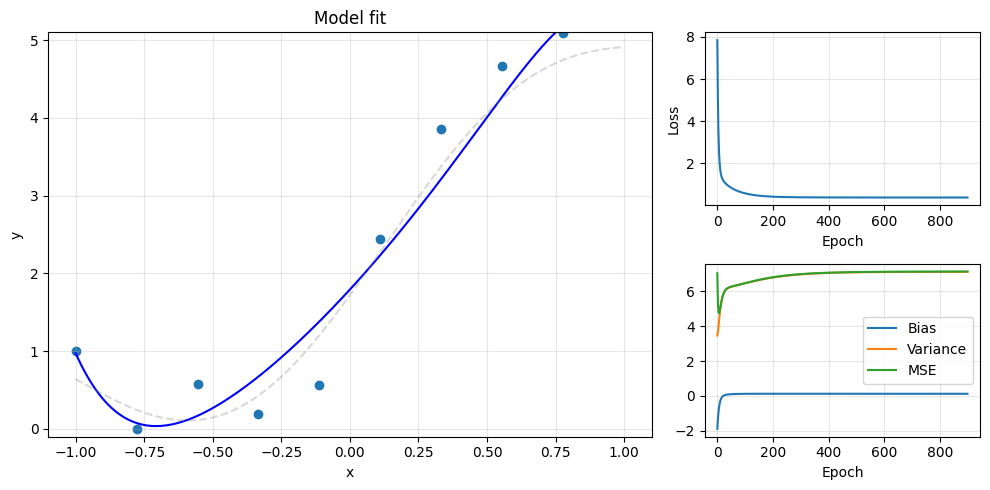

Training:  45%|████▌     | 901/2000 [00:08<00:09, 110.31it/s]

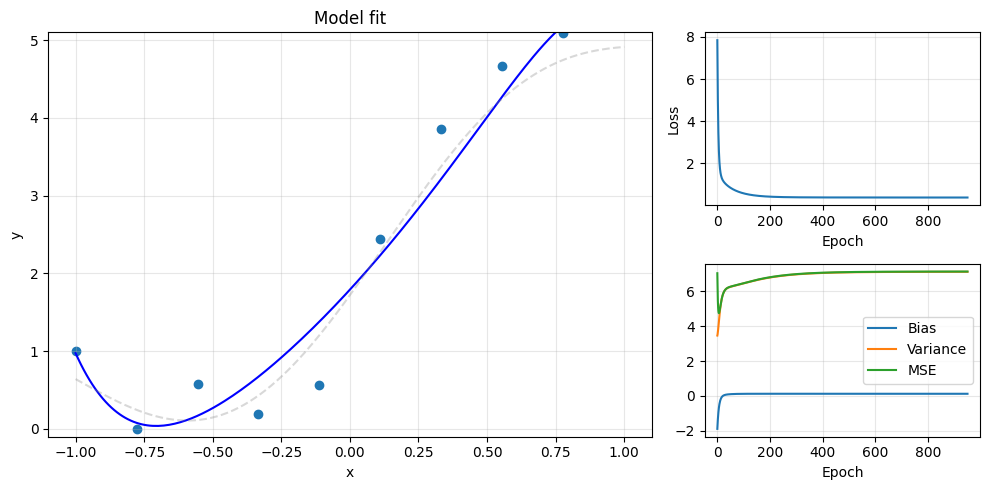

Training:  48%|████▊     | 951/2000 [00:09<00:09, 114.06it/s]

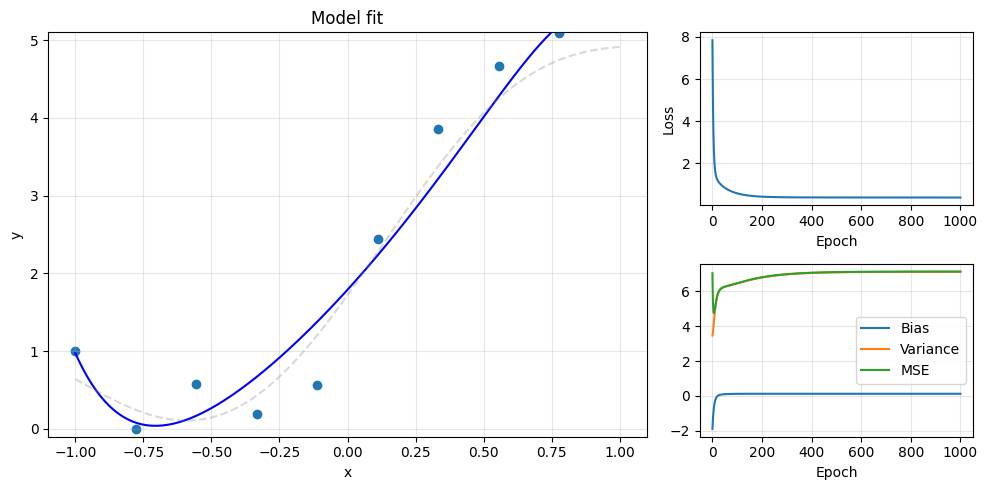

Training:  50%|█████     | 1001/2000 [00:09<00:08, 123.07it/s]

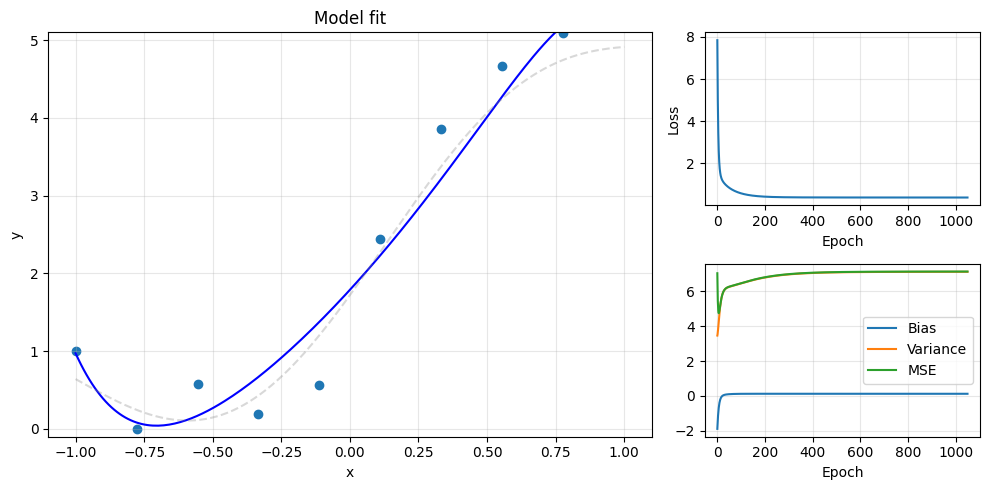

Training:  53%|█████▎    | 1051/2000 [00:09<00:07, 130.02it/s]

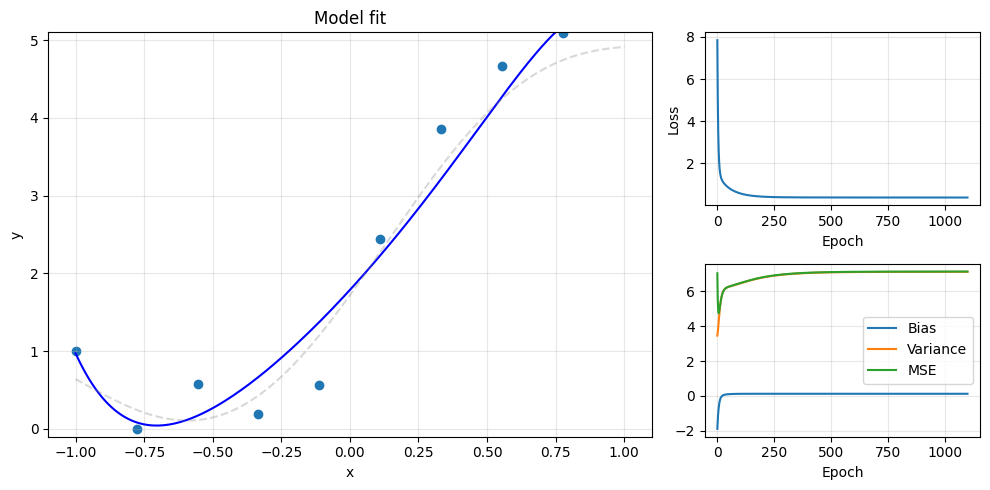

Training:  55%|█████▌    | 1101/2000 [00:10<00:06, 135.60it/s]

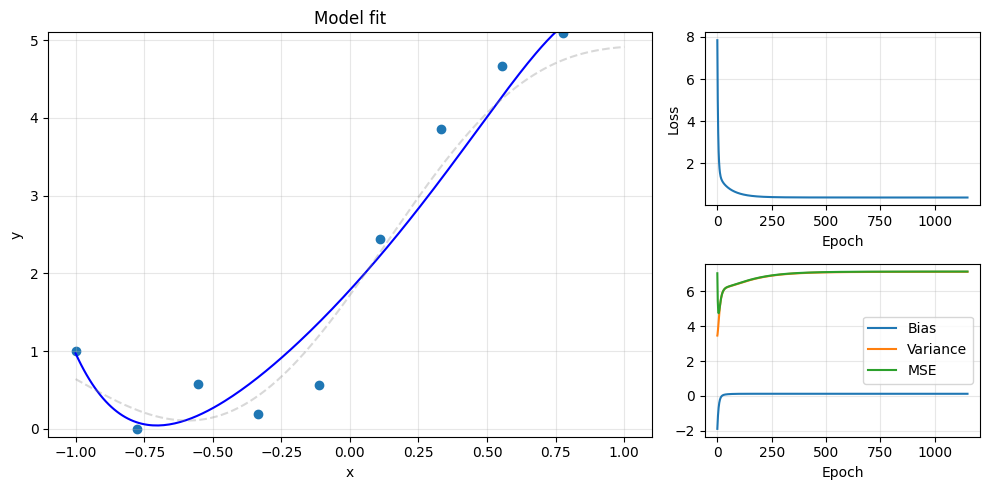

Training:  58%|█████▊    | 1151/2000 [00:10<00:06, 134.08it/s]

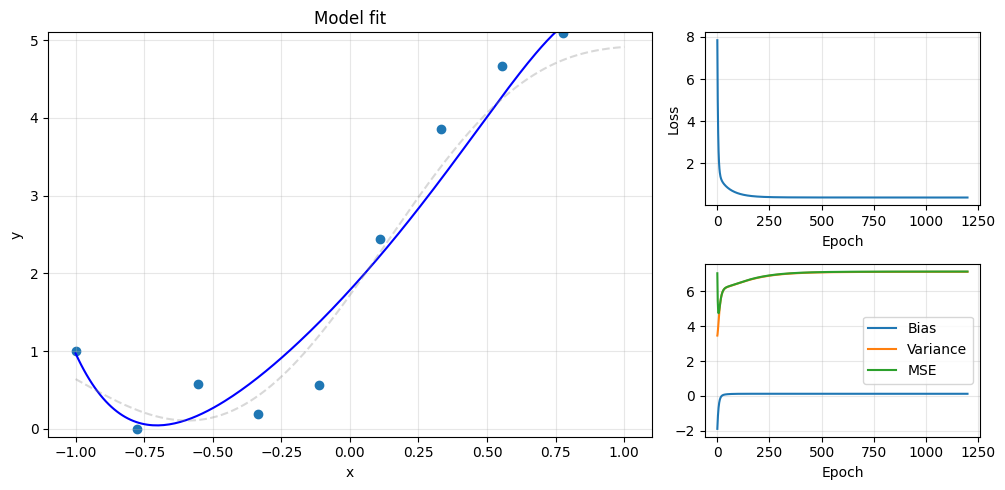

Training:  60%|██████    | 1201/2000 [00:10<00:06, 131.74it/s]

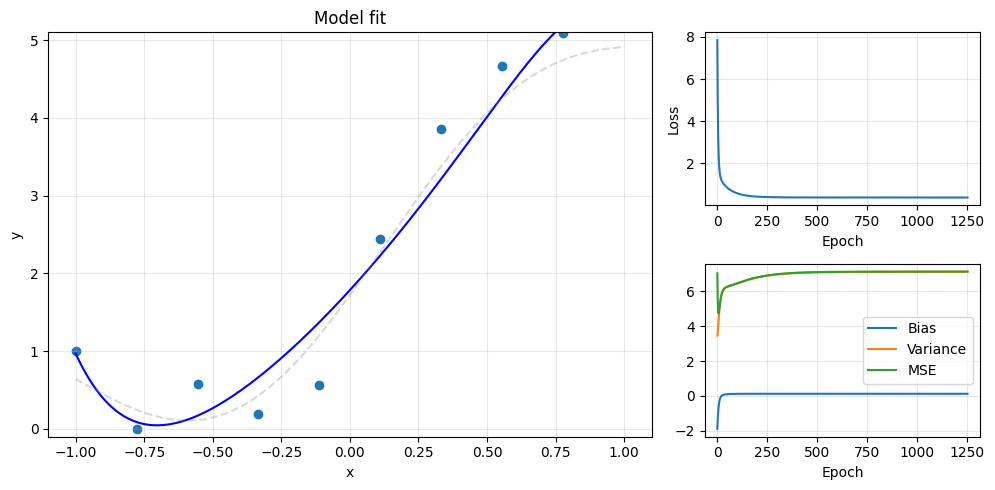

Training:  63%|██████▎   | 1251/2000 [00:11<00:05, 131.33it/s]

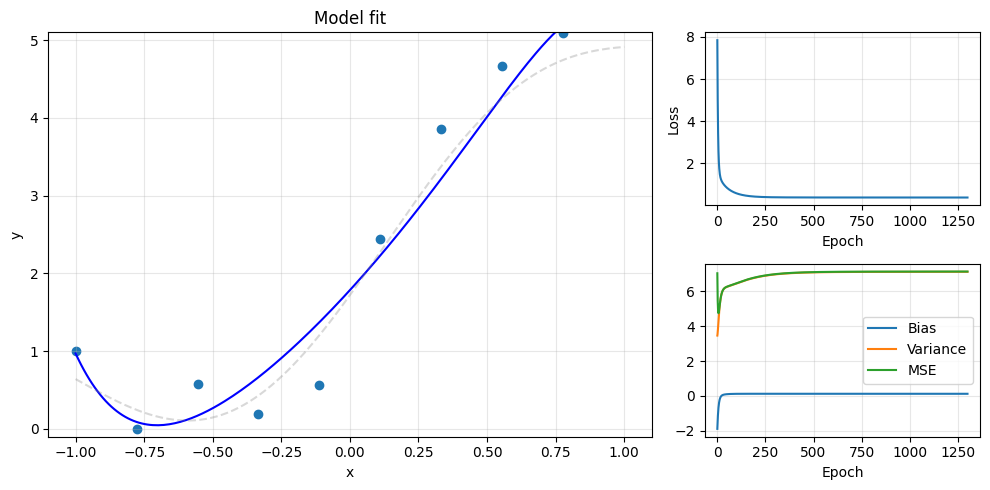

Training:  65%|██████▌   | 1301/2000 [00:12<00:07, 92.39it/s] 

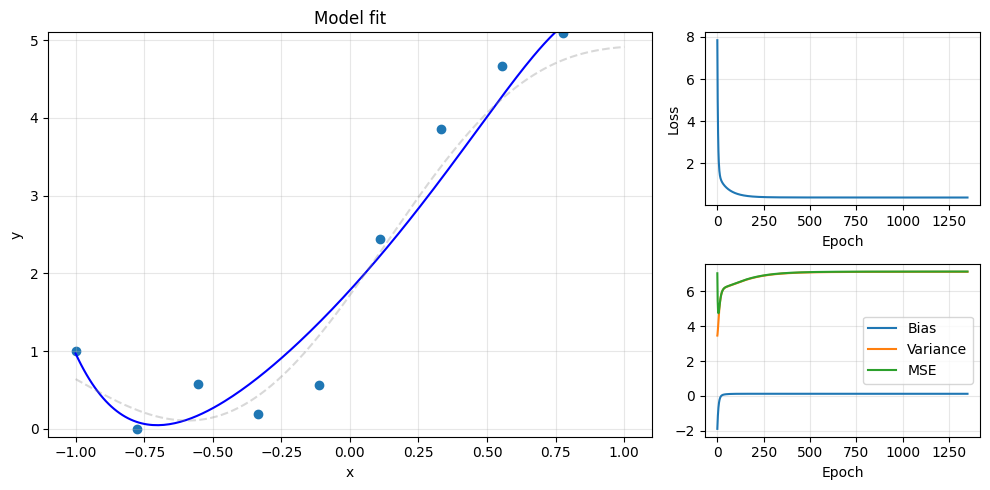

Training:  68%|██████▊   | 1351/2000 [00:12<00:06, 100.82it/s]

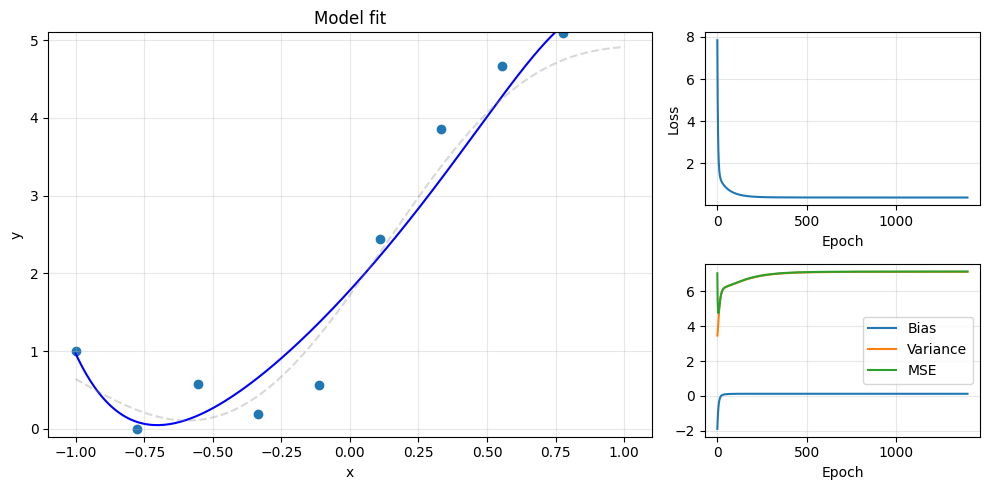

Training:  70%|███████   | 1401/2000 [00:12<00:05, 111.67it/s]

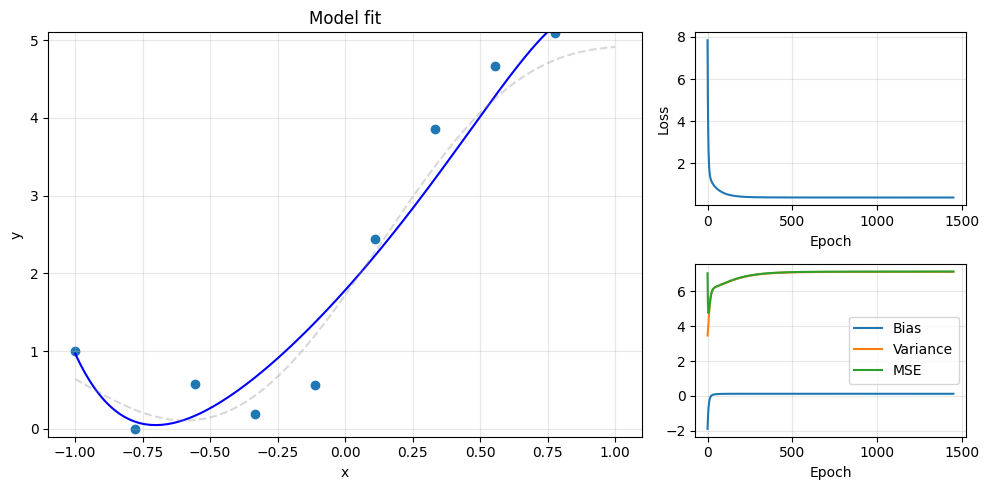

Training:  73%|███████▎  | 1451/2000 [00:13<00:04, 120.07it/s]

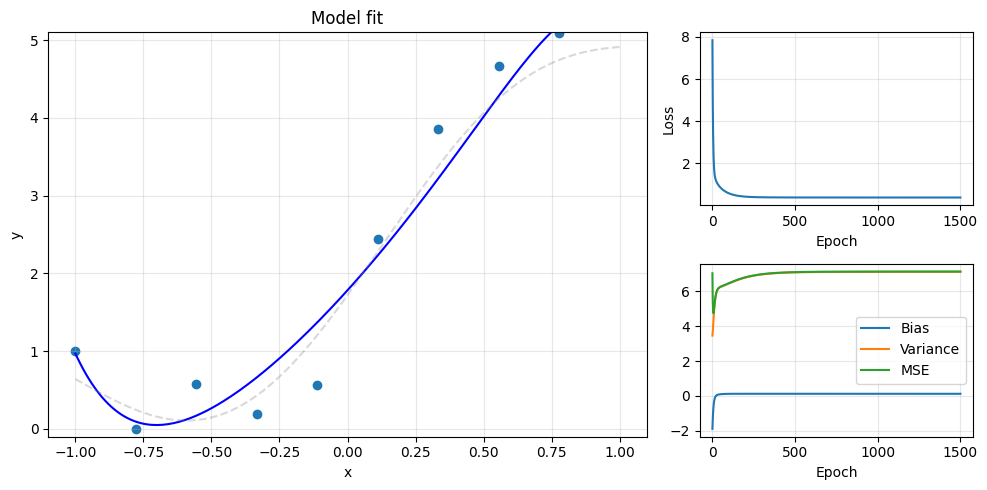

Training:  75%|███████▌  | 1501/2000 [00:13<00:03, 129.33it/s]

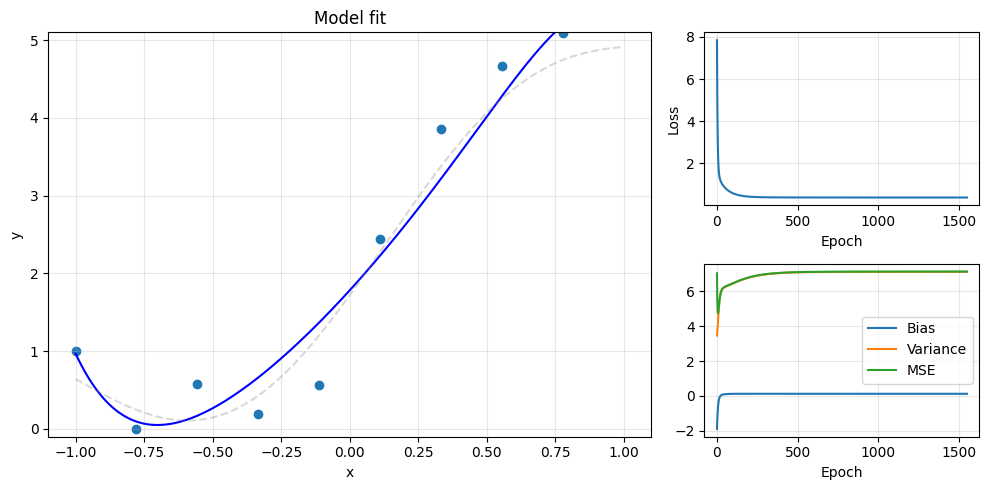

Training:  78%|███████▊  | 1551/2000 [00:13<00:03, 134.68it/s]

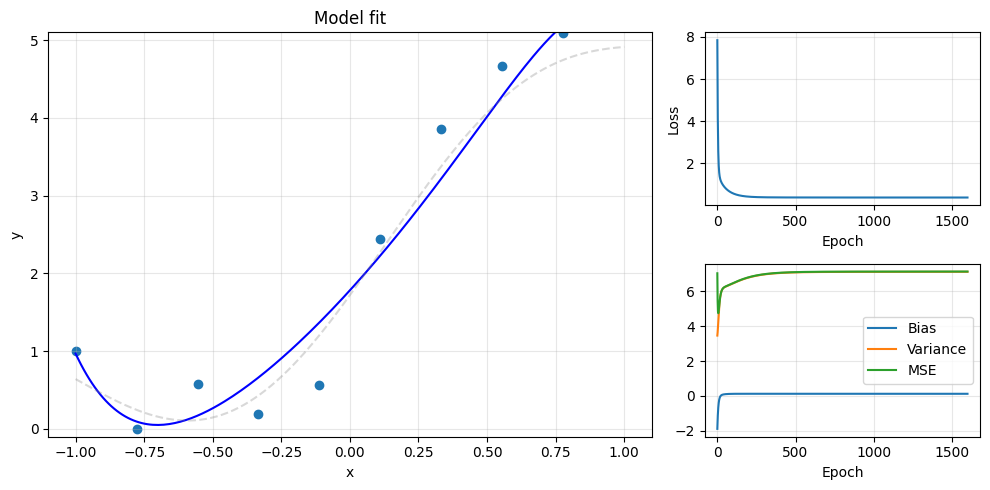

Training:  80%|████████  | 1601/2000 [00:14<00:02, 138.76it/s]

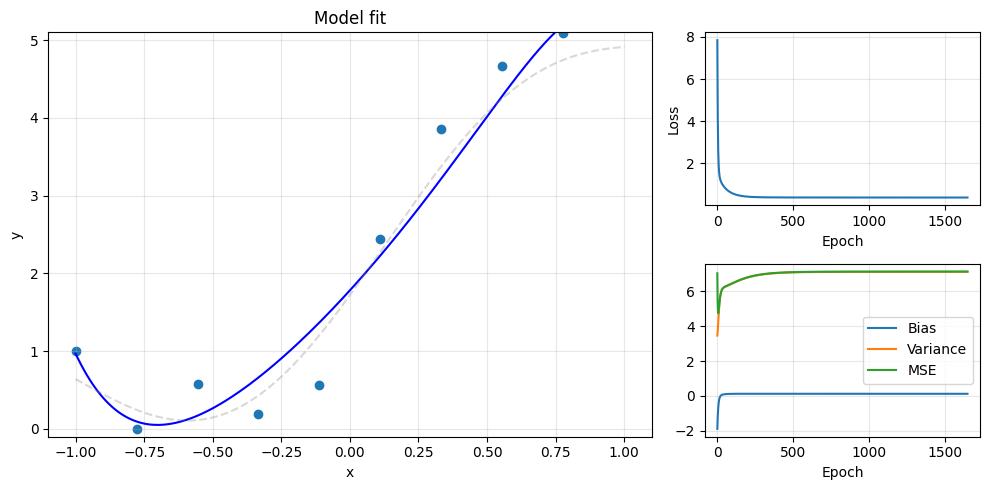

Training:  83%|████████▎ | 1651/2000 [00:14<00:02, 139.61it/s]

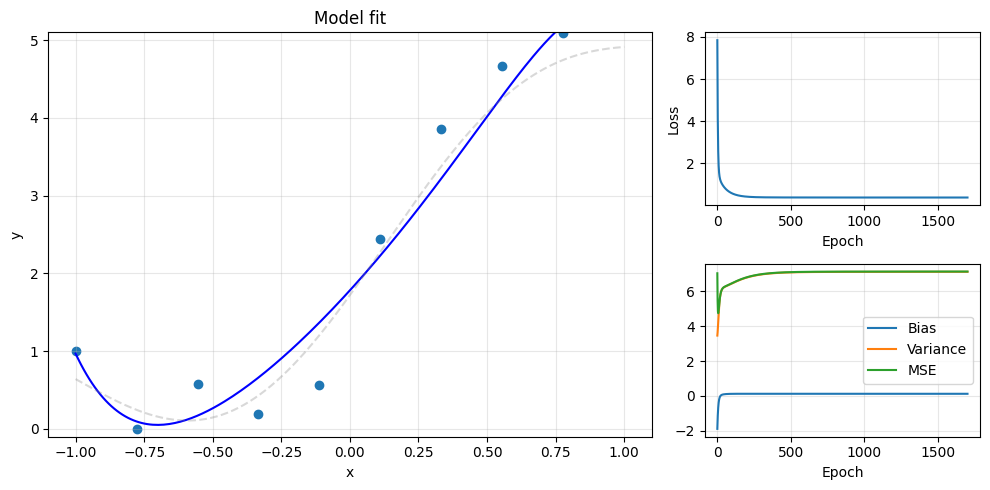

Training:  85%|████████▌ | 1701/2000 [00:14<00:02, 137.70it/s]

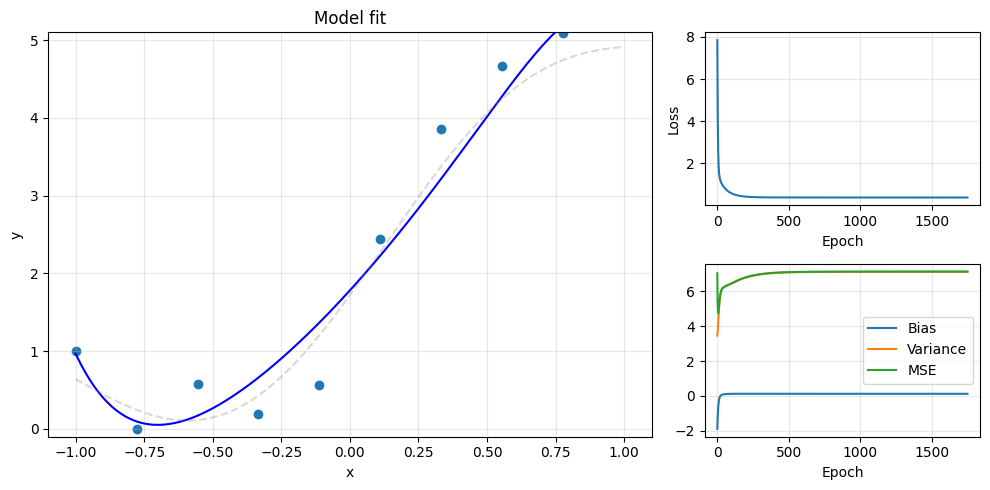

Training:  88%|████████▊ | 1751/2000 [00:15<00:01, 134.06it/s]

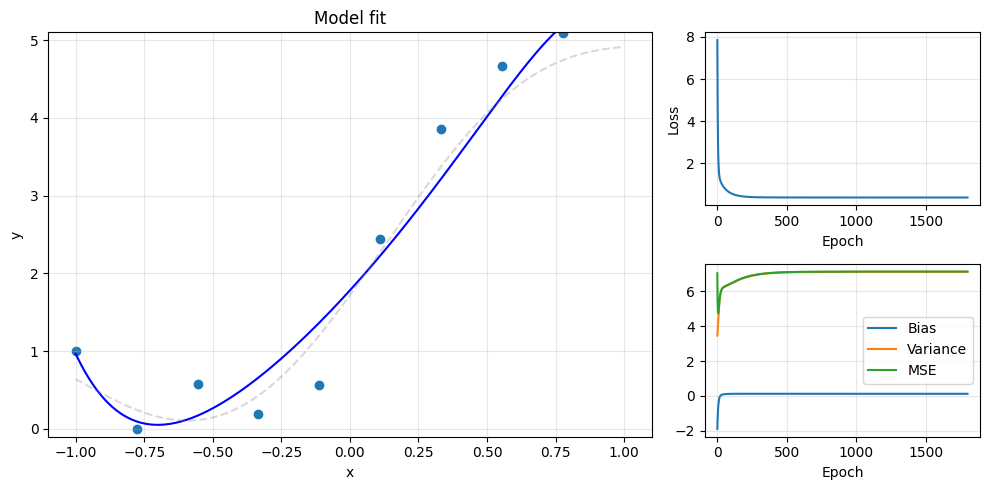

Training:  90%|█████████ | 1801/2000 [00:16<00:02, 97.26it/s] 

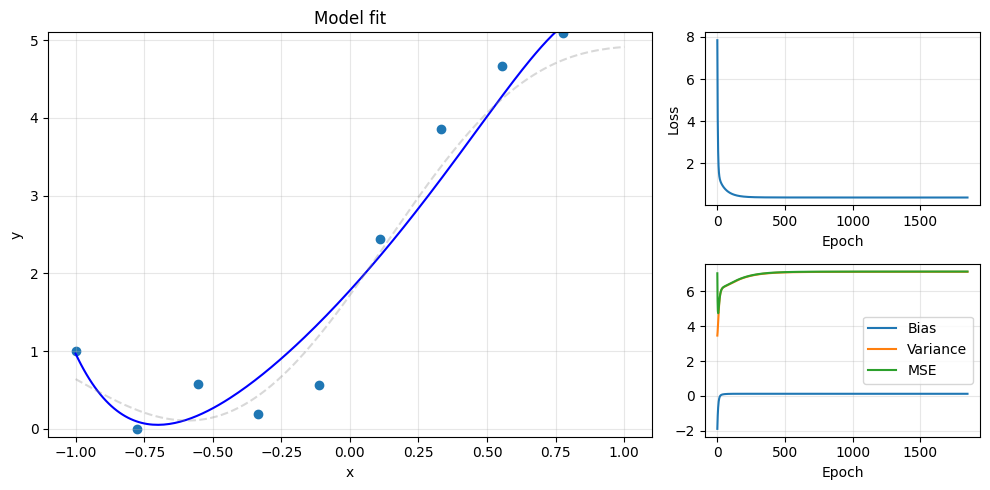

Training:  93%|█████████▎| 1851/2000 [00:16<00:01, 106.86it/s]

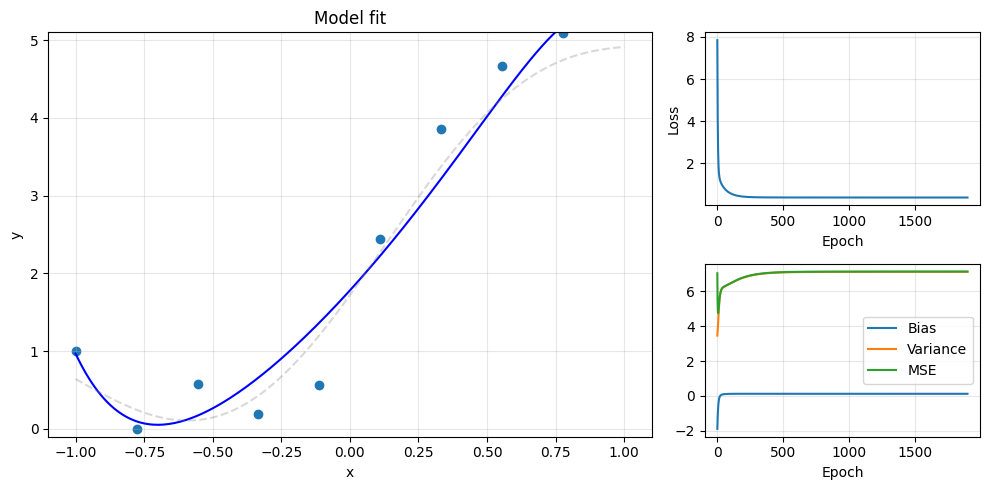

Training:  95%|█████████▌| 1901/2000 [00:17<00:00, 102.71it/s]

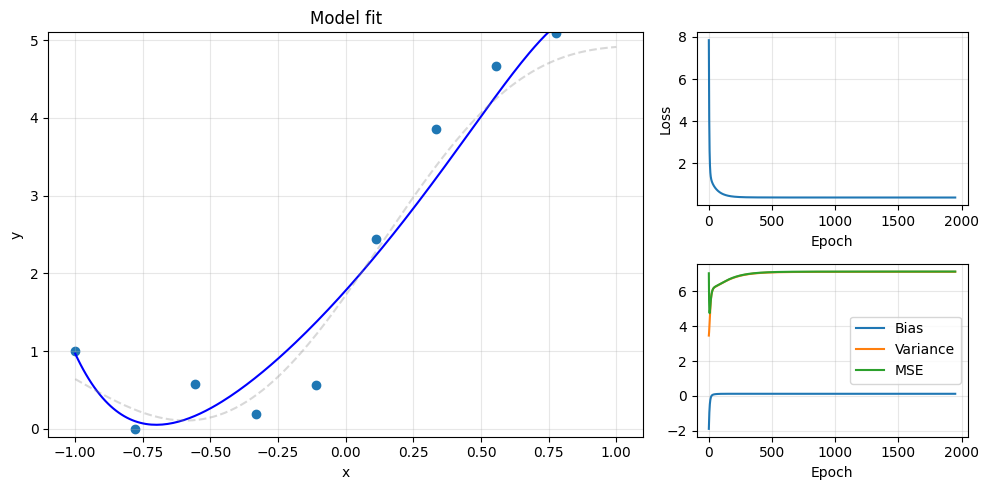

Training:  98%|█████████▊| 1951/2000 [00:17<00:00, 100.76it/s]

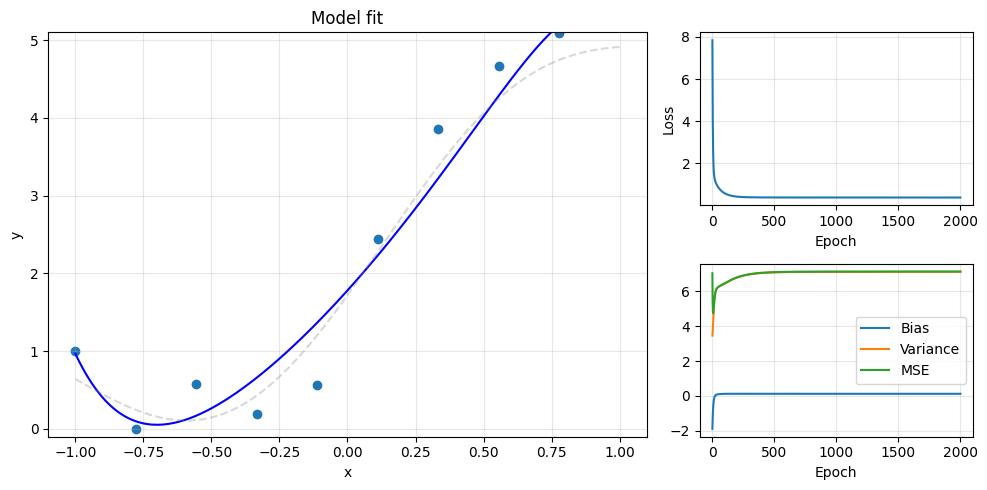

In [26]:
#training with different regularisation strengths
X_tensor = torch.tensor(df['x']).float().view(-1, 1)
y_tensor = torch.tensor(df['y']).float().view(-1, 1)

print("Training high-degree polynomial WITH regularisation (lambda=0.01):")
model_reg = PolynomialModel(degree=8)
_ = train_polynomial(model_reg, X_tensor, y_tensor, epochs=2000, lambda_l2=0.01, plot_freq=250)

Training high-degree polynomial WITHOUT regularisation:


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

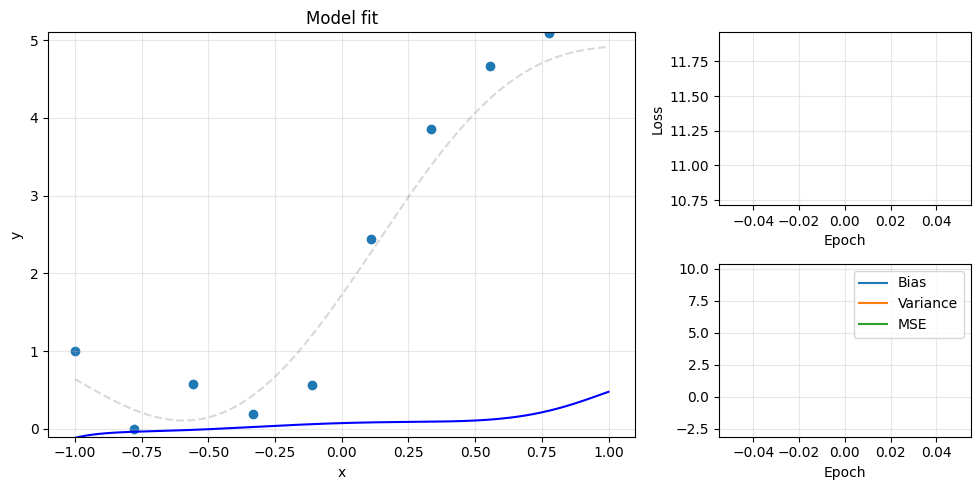

Training:   0%|          | 1/2000 [00:00<13:37,  2.45it/s]

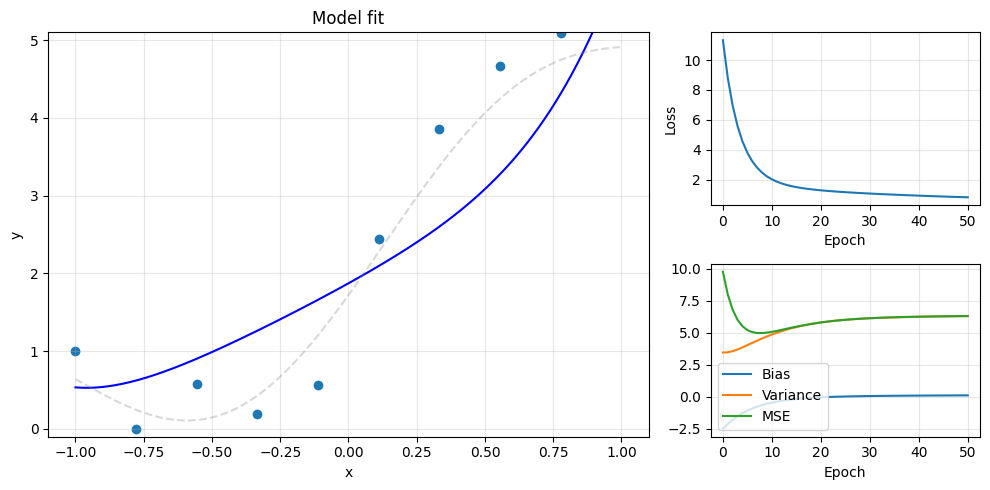

Training:   3%|▎         | 51/2000 [00:00<00:24, 79.40it/s]

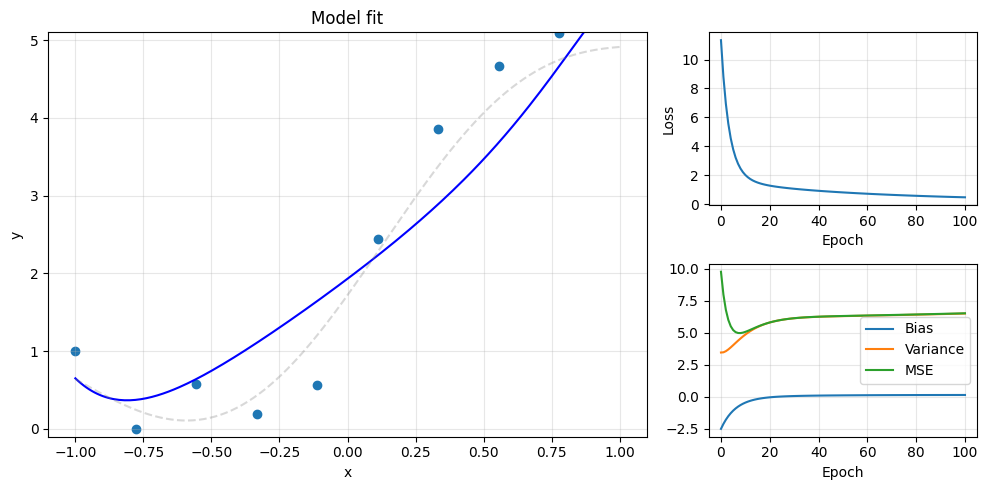

Training:   5%|▌         | 101/2000 [00:01<00:17, 106.00it/s]

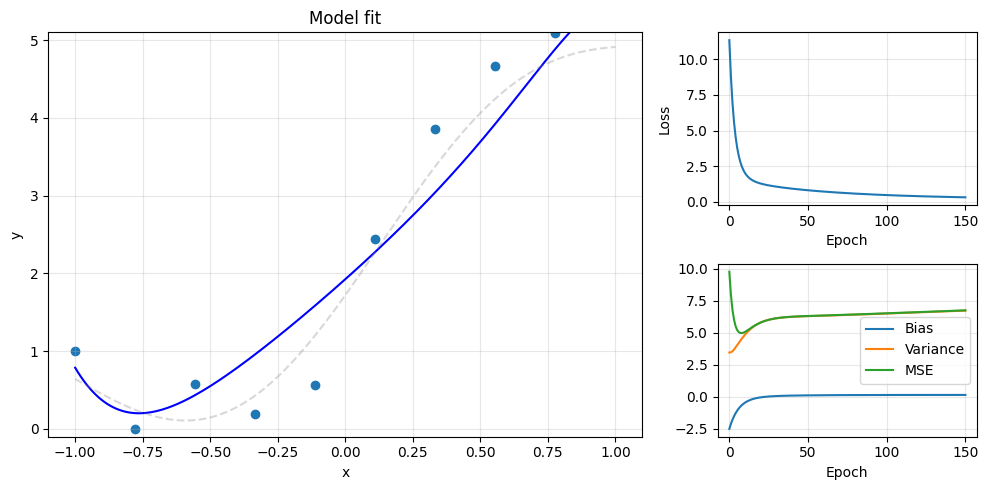

Training:   8%|▊         | 151/2000 [00:01<00:14, 124.40it/s]

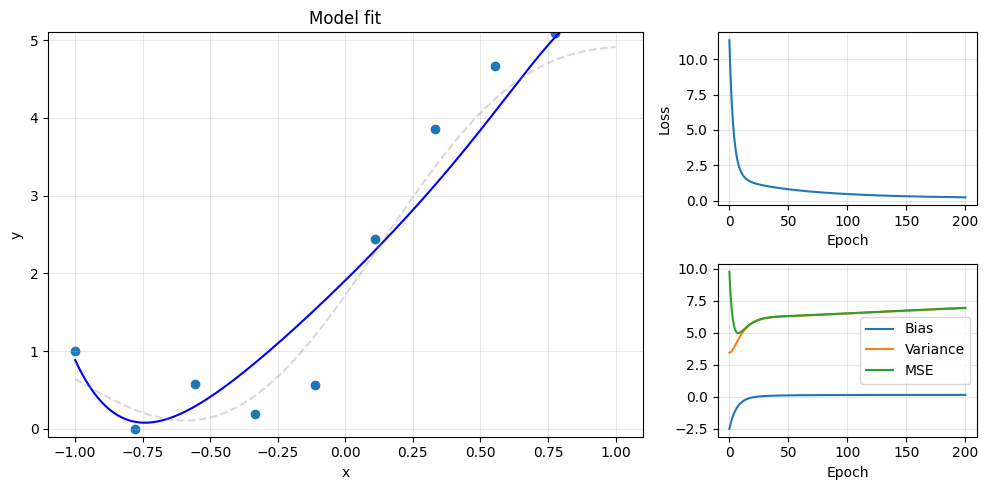

Training:  10%|█         | 201/2000 [00:01<00:13, 133.73it/s]

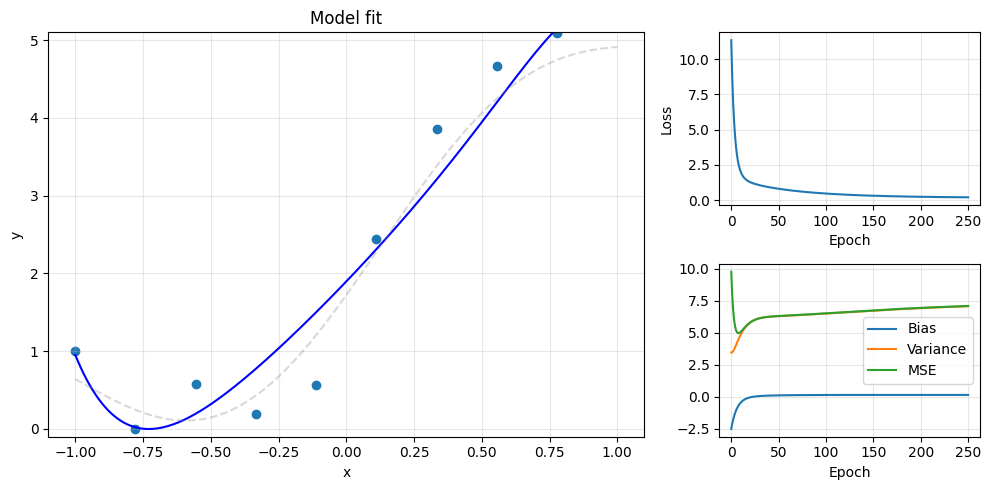

Training:  13%|█▎        | 251/2000 [00:02<00:19, 89.69it/s] 

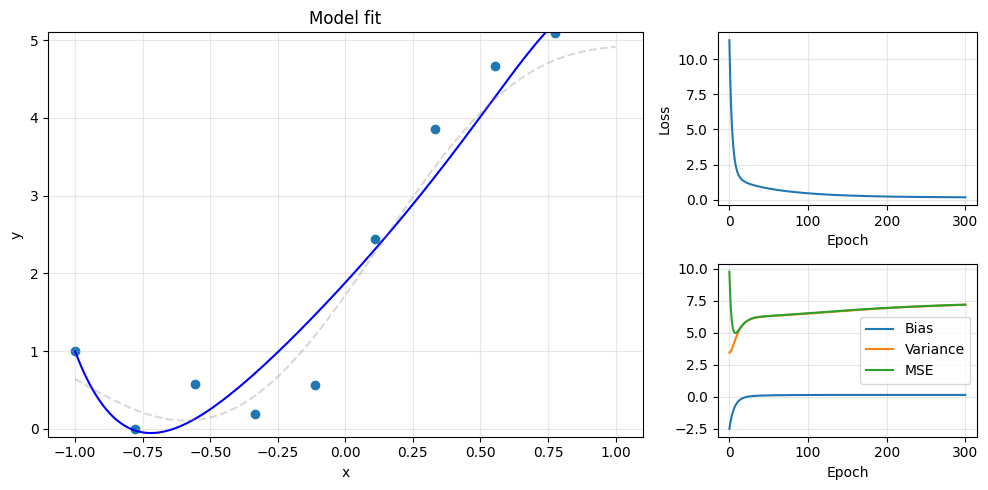

Training:  15%|█▌        | 301/2000 [00:03<00:16, 102.28it/s]

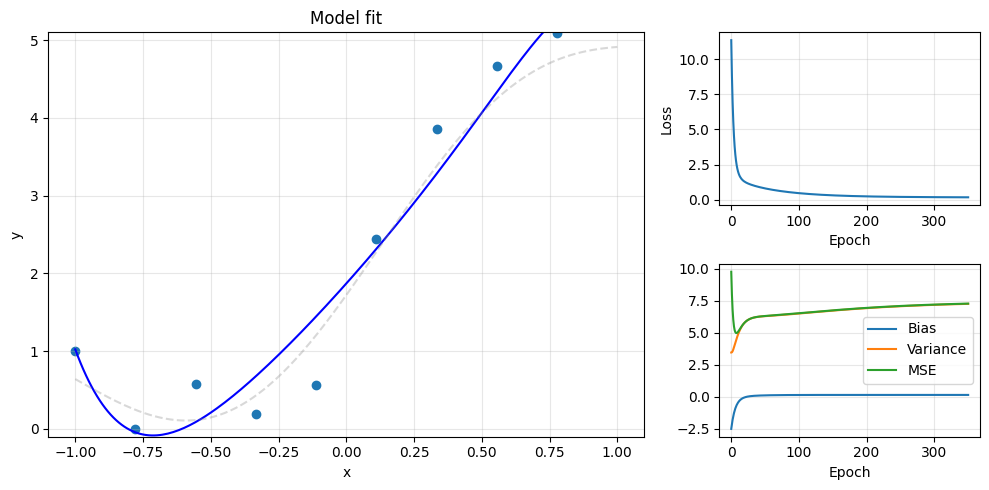

Training:  18%|█▊        | 351/2000 [00:03<00:14, 113.85it/s]

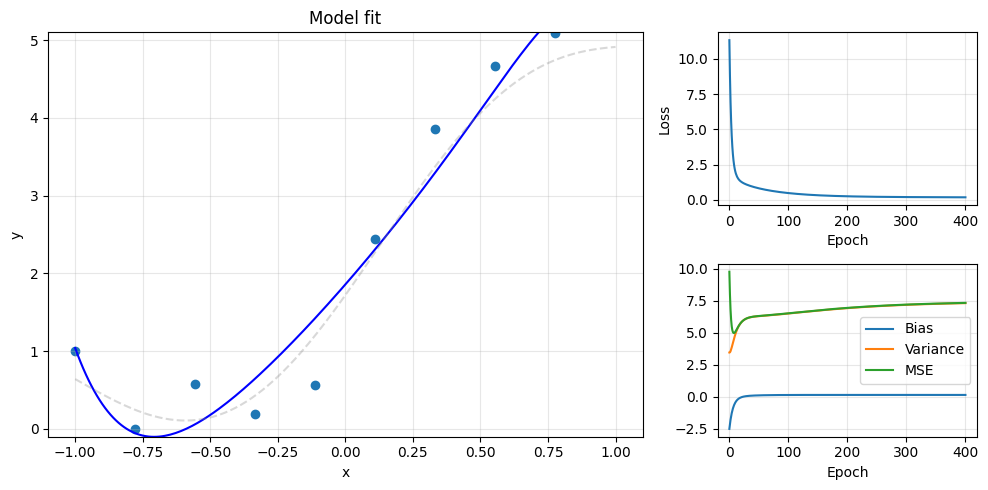

Training:  20%|██        | 401/2000 [00:03<00:12, 125.20it/s]

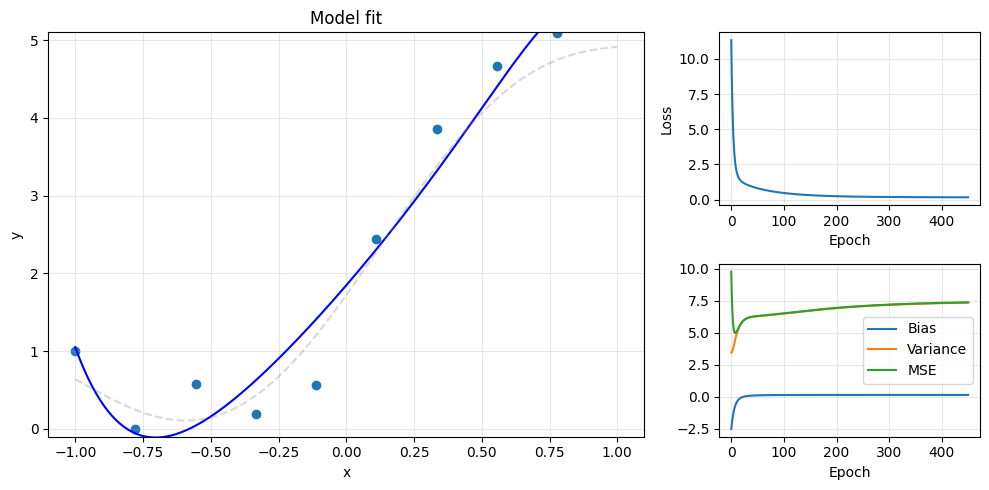

Training:  23%|██▎       | 451/2000 [00:03<00:11, 132.73it/s]

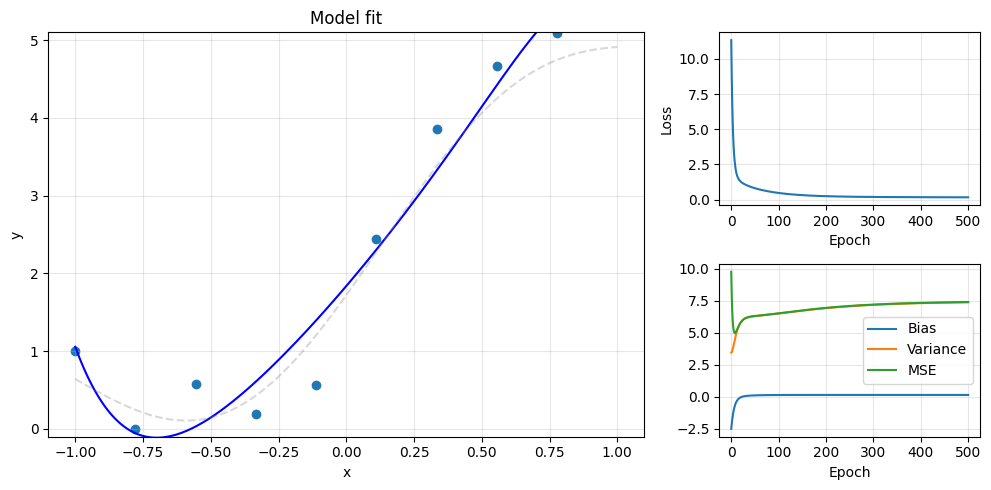

Training:  25%|██▌       | 501/2000 [00:04<00:10, 138.01it/s]

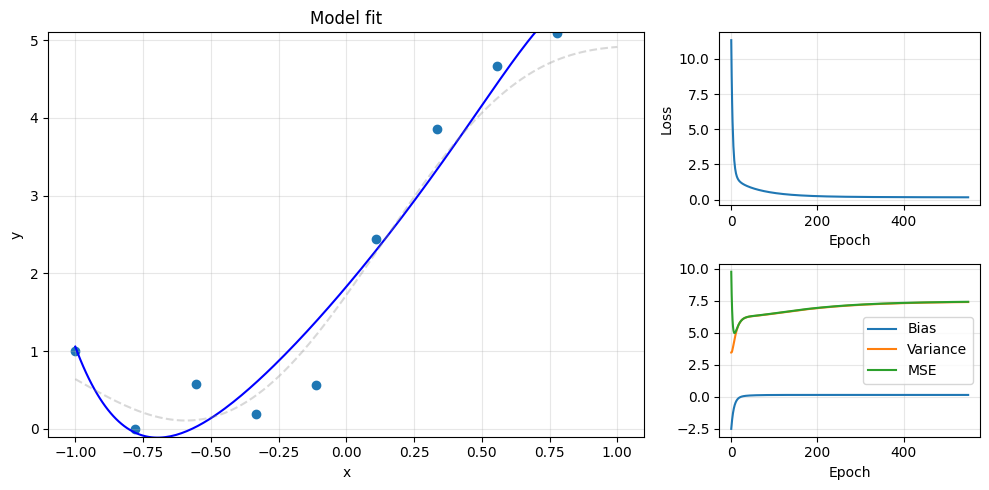

Training:  28%|██▊       | 551/2000 [00:04<00:10, 139.03it/s]

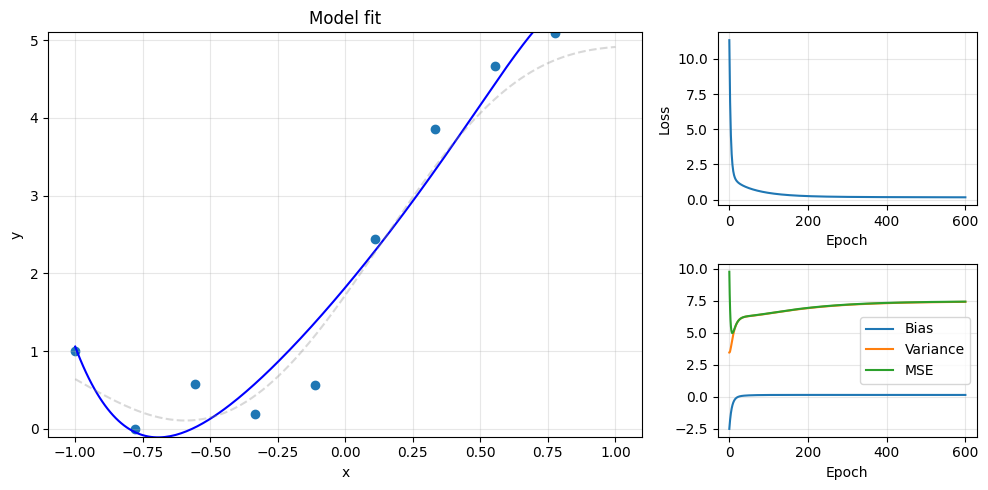

Training:  30%|███       | 601/2000 [00:05<00:10, 139.81it/s]

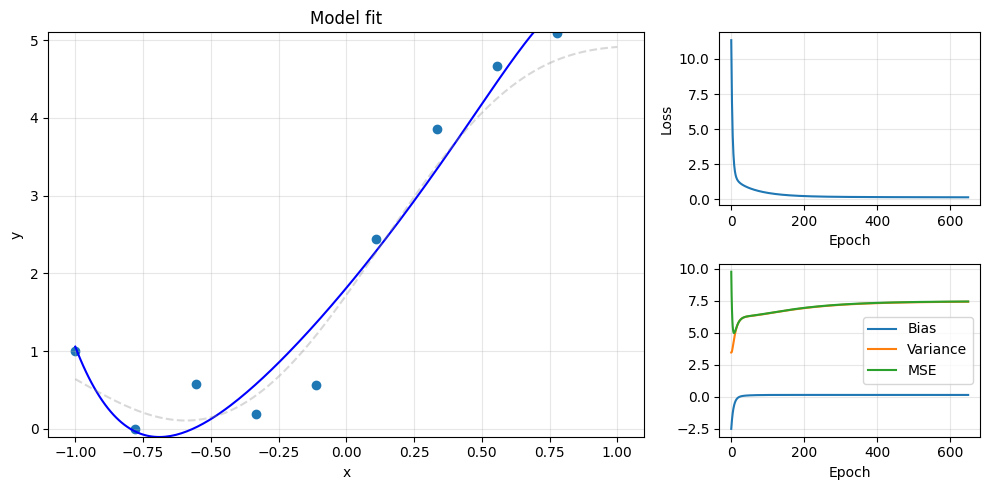

Training:  33%|███▎      | 651/2000 [00:05<00:09, 139.16it/s]

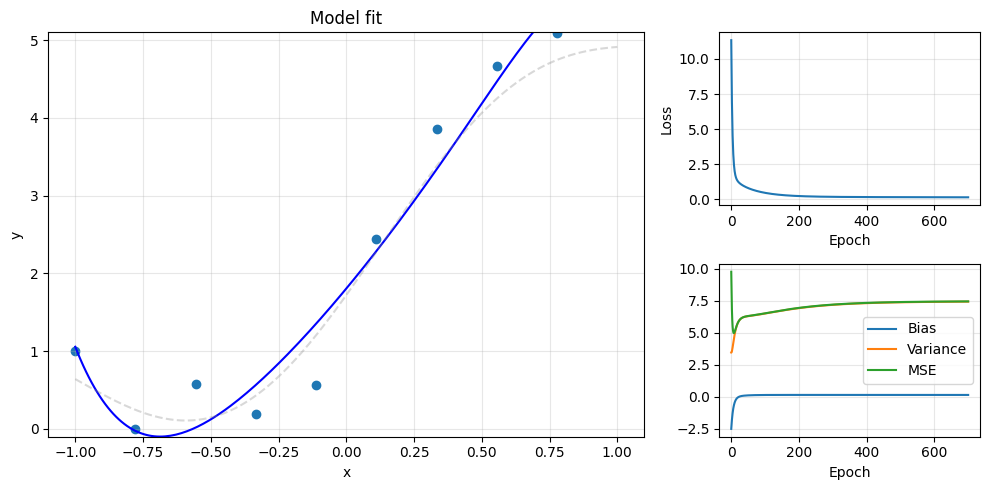

Training:  35%|███▌      | 701/2000 [00:05<00:09, 134.35it/s]

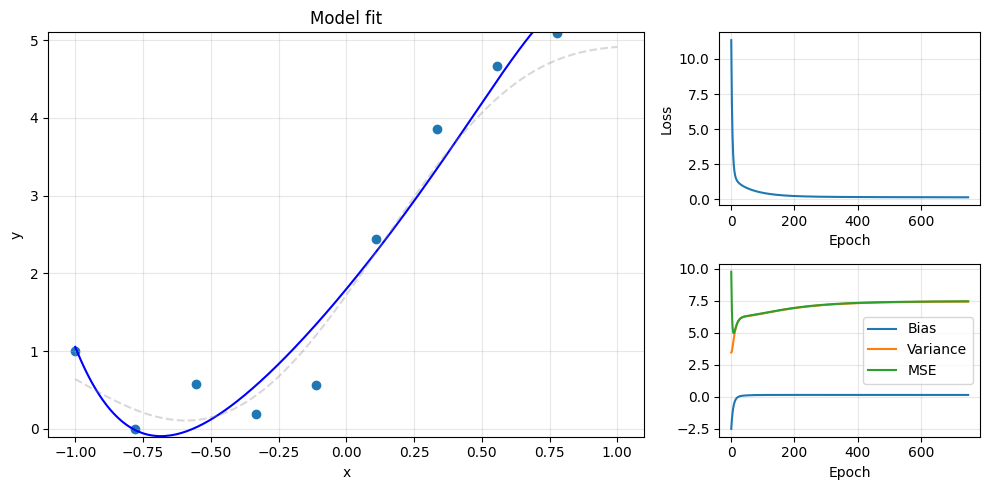

Training:  38%|███▊      | 751/2000 [00:06<00:13, 92.69it/s] 

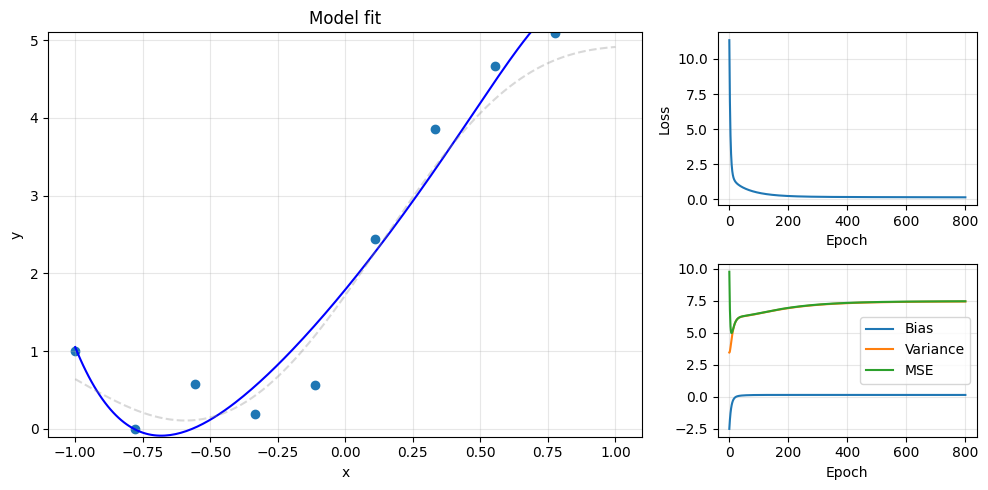

Training:  40%|████      | 801/2000 [00:07<00:11, 103.01it/s]

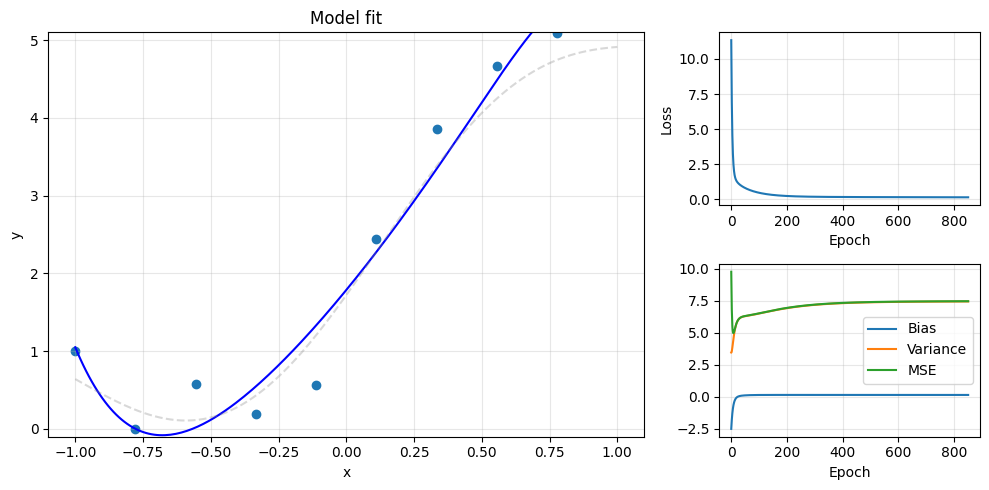

Training:  43%|████▎     | 851/2000 [00:07<00:10, 112.81it/s]

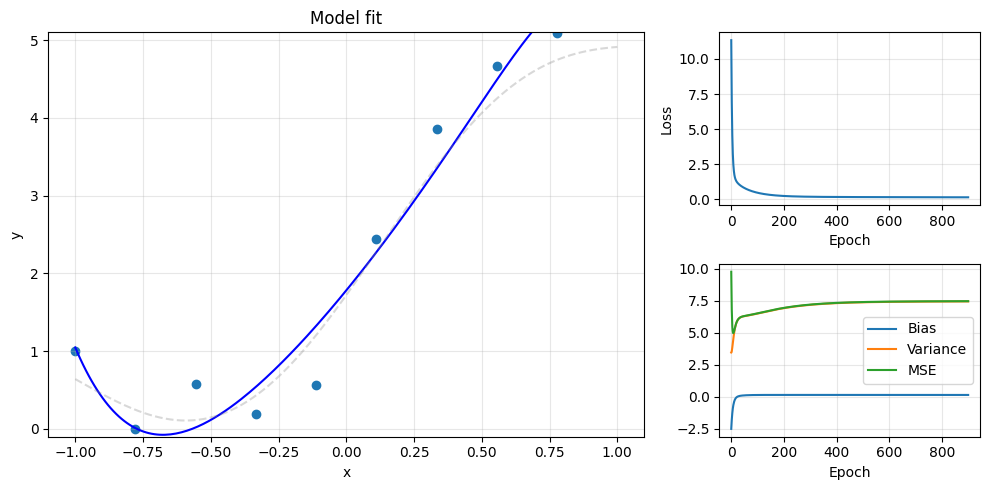

Training:  45%|████▌     | 901/2000 [00:07<00:08, 122.37it/s]

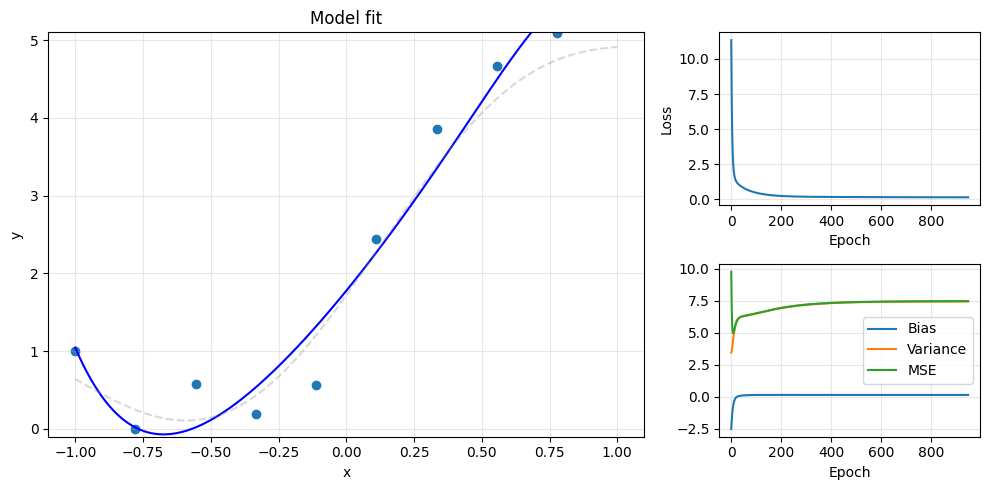

Training:  48%|████▊     | 951/2000 [00:08<00:08, 128.30it/s]

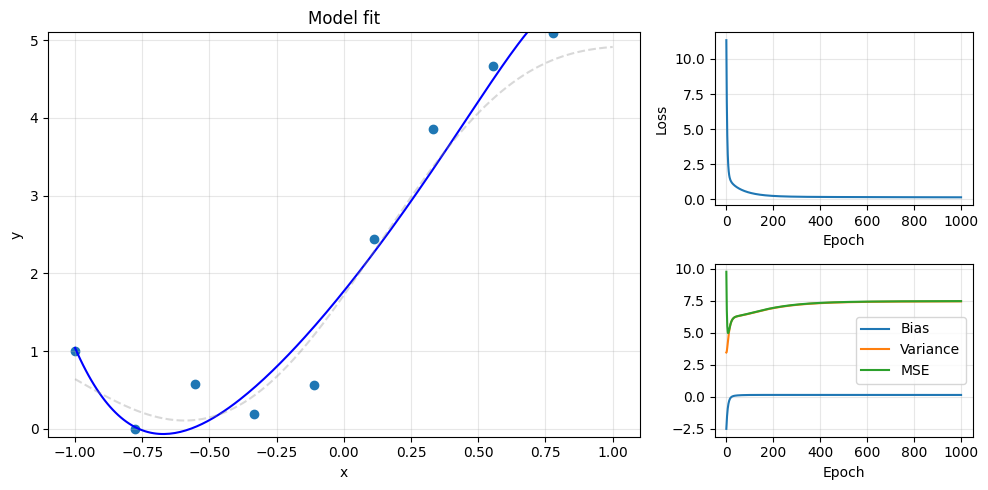

Training:  50%|█████     | 1001/2000 [00:08<00:07, 127.58it/s]

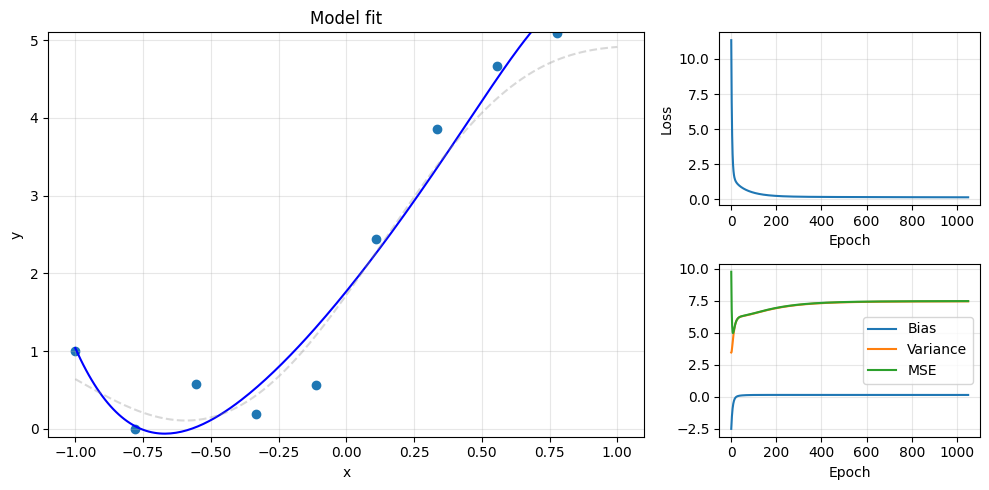

Training:  53%|█████▎    | 1051/2000 [00:08<00:07, 128.16it/s]

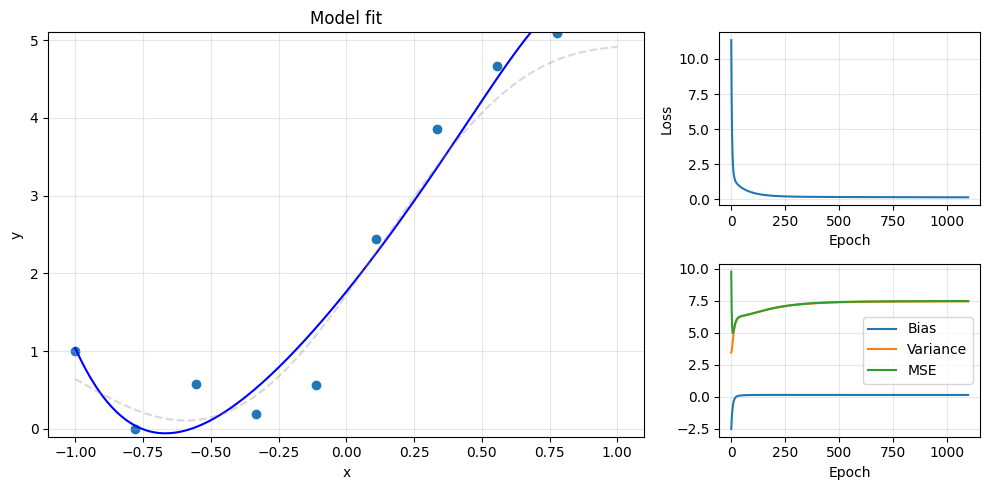

Training:  55%|█████▌    | 1101/2000 [00:09<00:06, 130.28it/s]

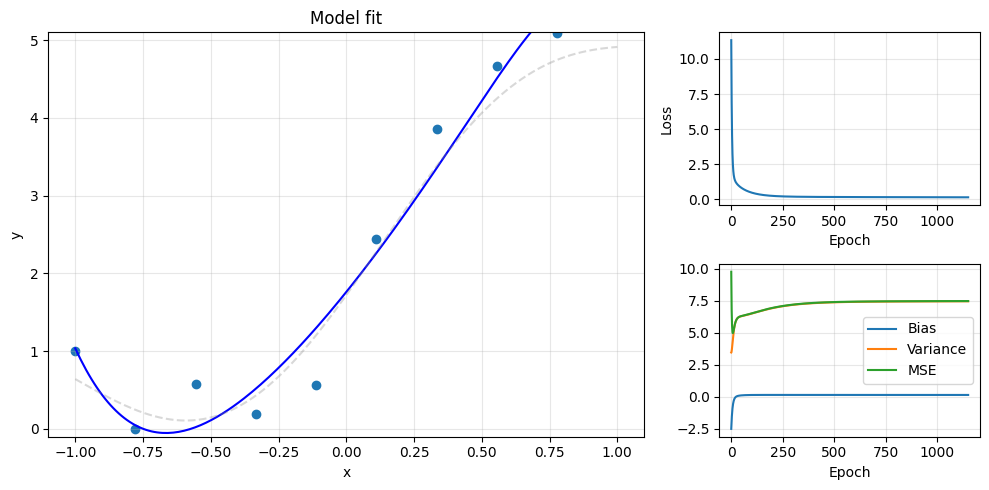

Training:  58%|█████▊    | 1151/2000 [00:09<00:06, 127.50it/s]

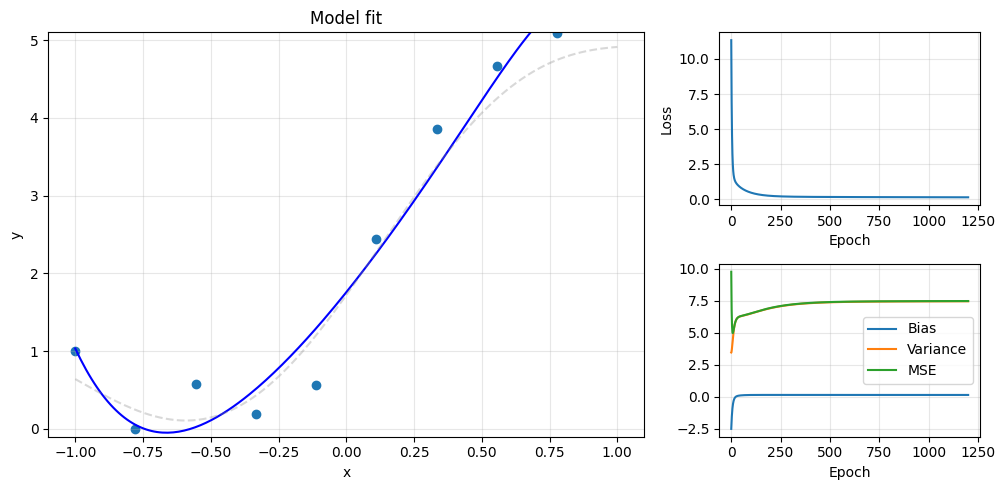

Training:  60%|██████    | 1201/2000 [00:10<00:06, 131.34it/s]

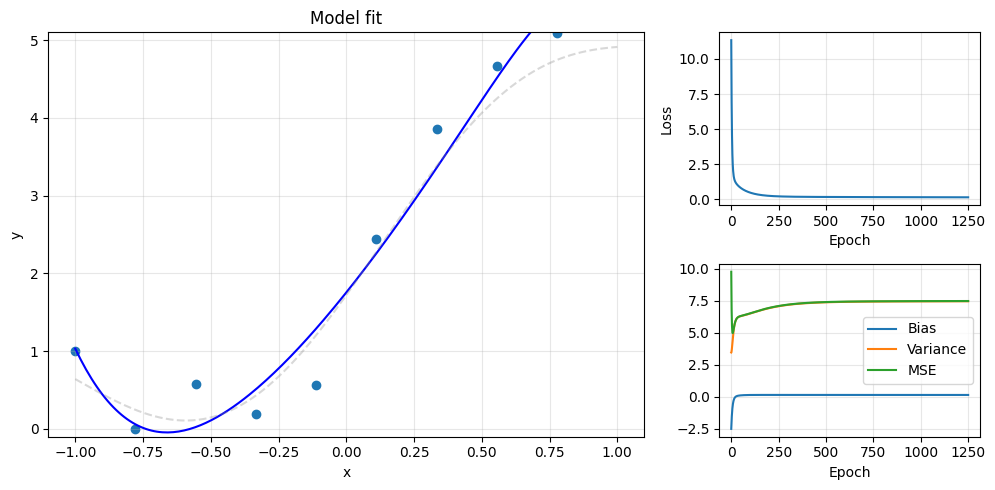

Training:  63%|██████▎   | 1251/2000 [00:11<00:08, 85.34it/s] 

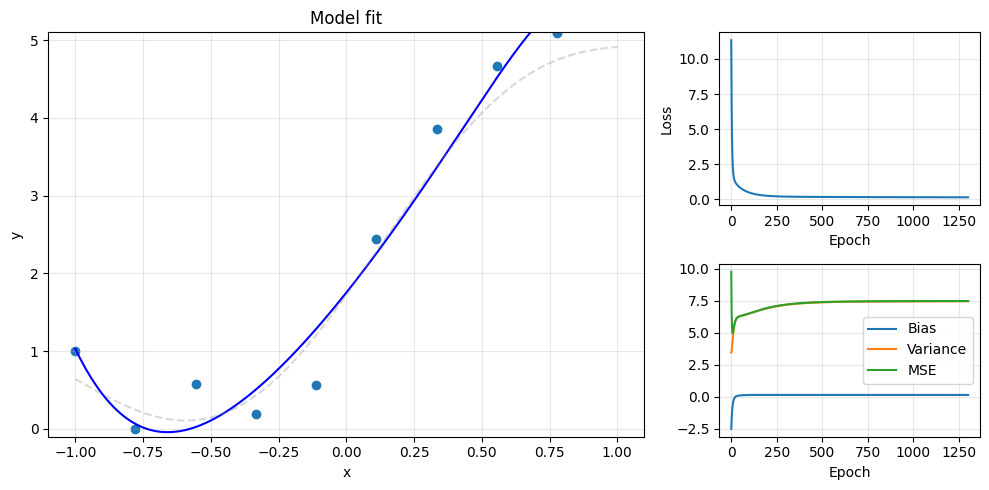

Training:  65%|██████▌   | 1301/2000 [00:11<00:08, 85.79it/s]

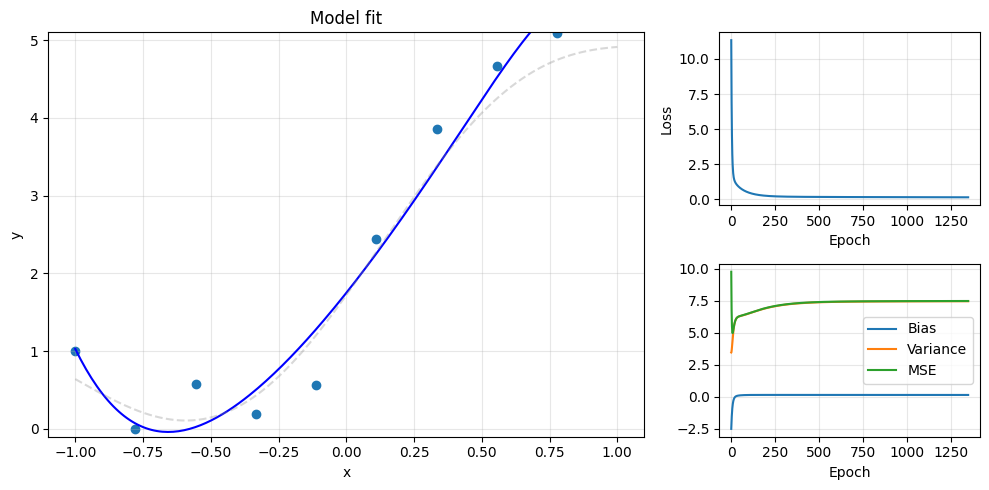

Training:  68%|██████▊   | 1351/2000 [00:11<00:06, 98.63it/s]

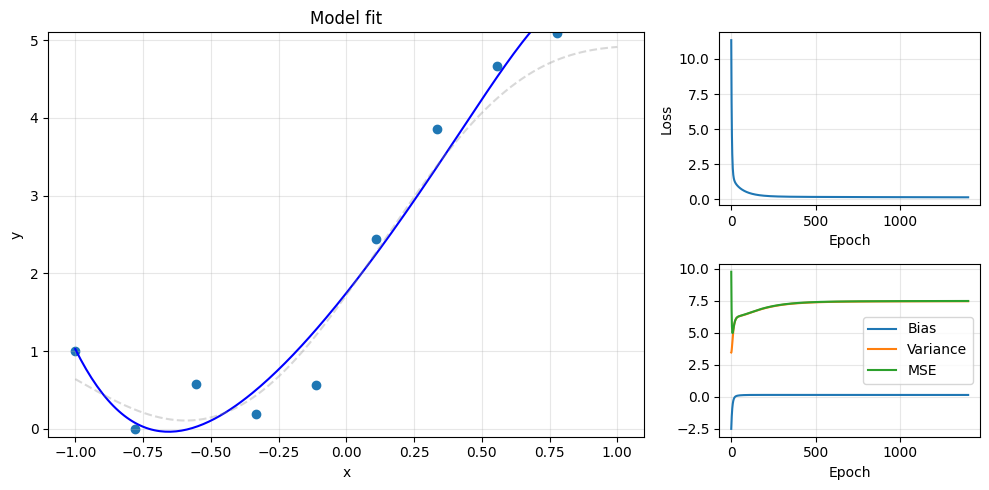

Training:  70%|███████   | 1401/2000 [00:12<00:05, 110.62it/s]

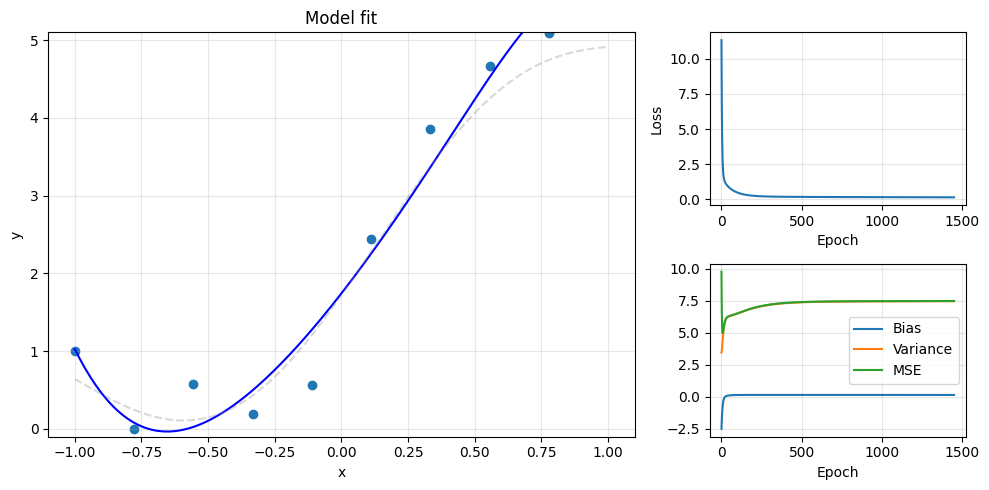

Training:  73%|███████▎  | 1451/2000 [00:12<00:04, 118.60it/s]

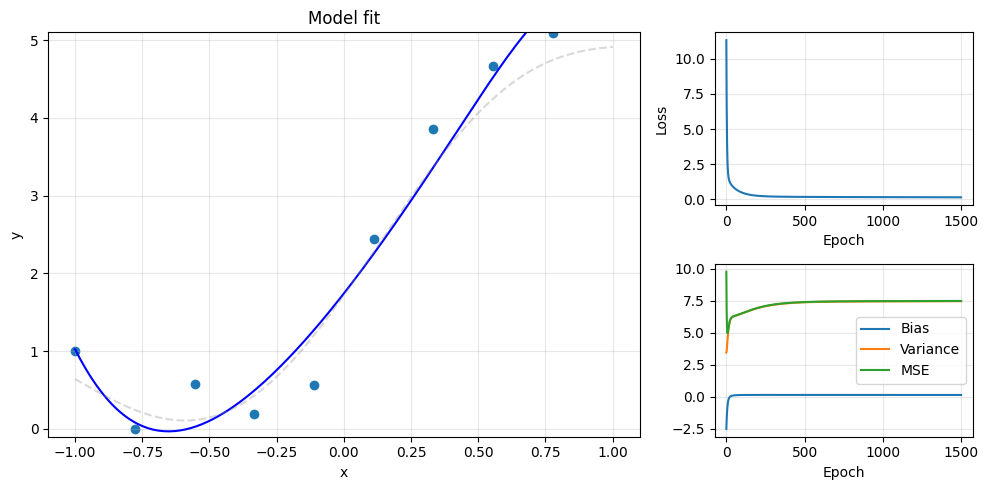

Training:  75%|███████▌  | 1501/2000 [00:13<00:04, 123.08it/s]

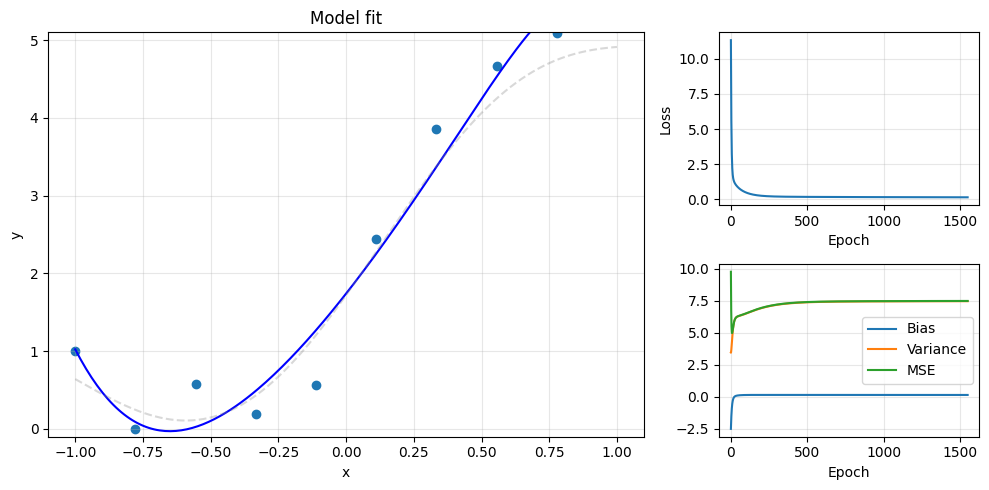

Training:  78%|███████▊  | 1551/2000 [00:13<00:03, 125.91it/s]

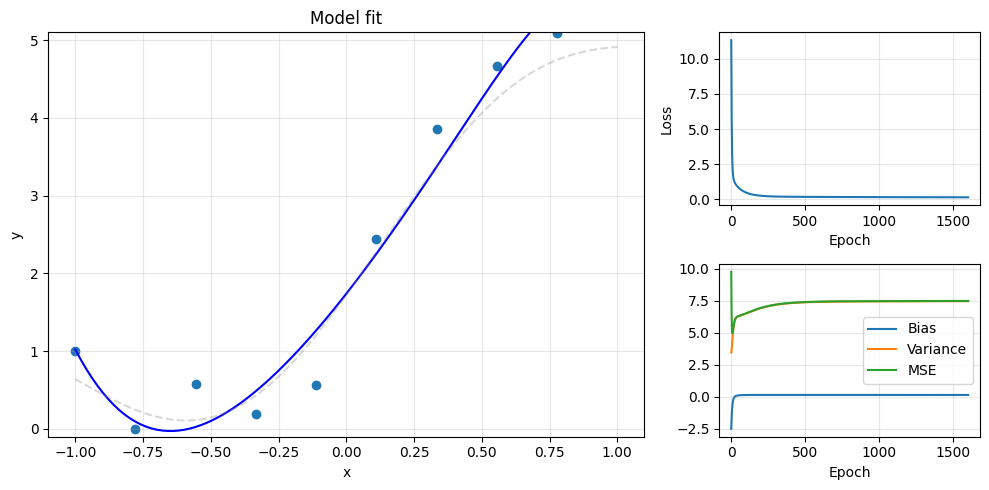

Training:  80%|████████  | 1601/2000 [00:13<00:03, 128.23it/s]

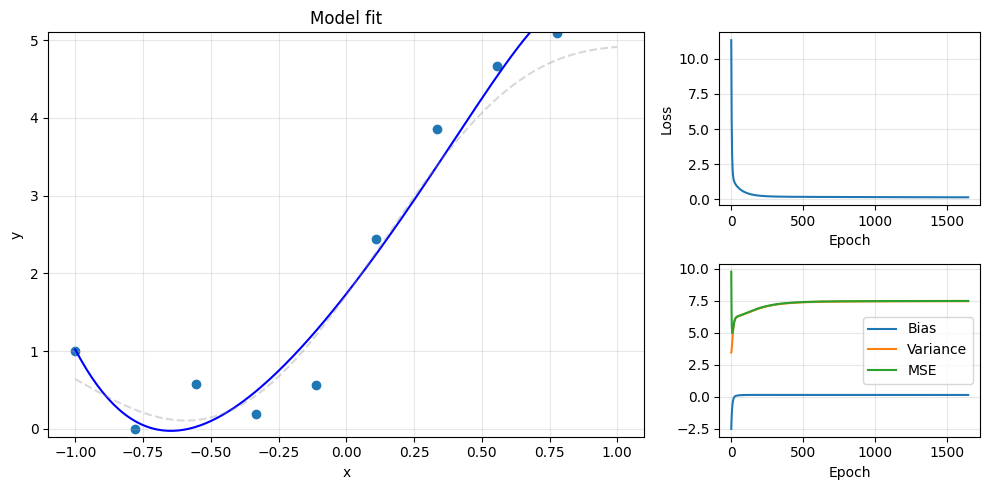

Training:  83%|████████▎ | 1651/2000 [00:14<00:02, 129.38it/s]

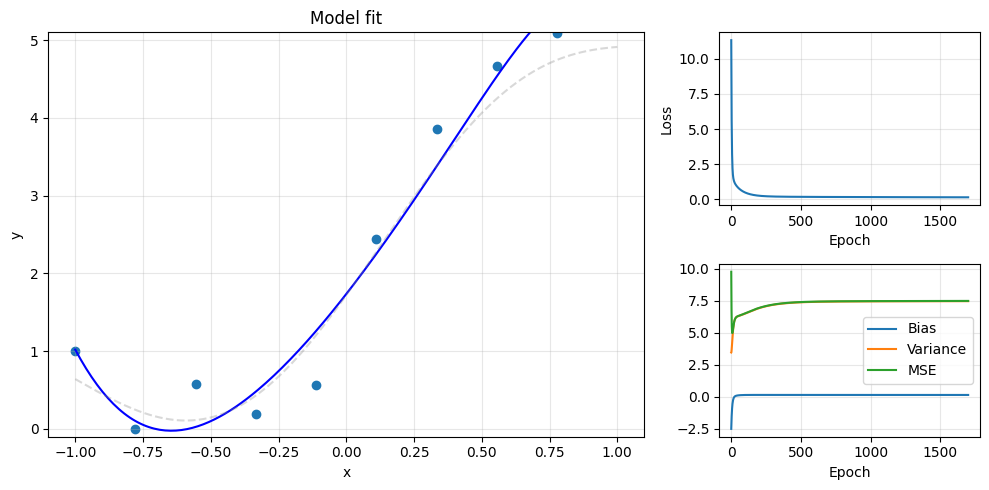

Training:  85%|████████▌ | 1701/2000 [00:14<00:02, 130.18it/s]

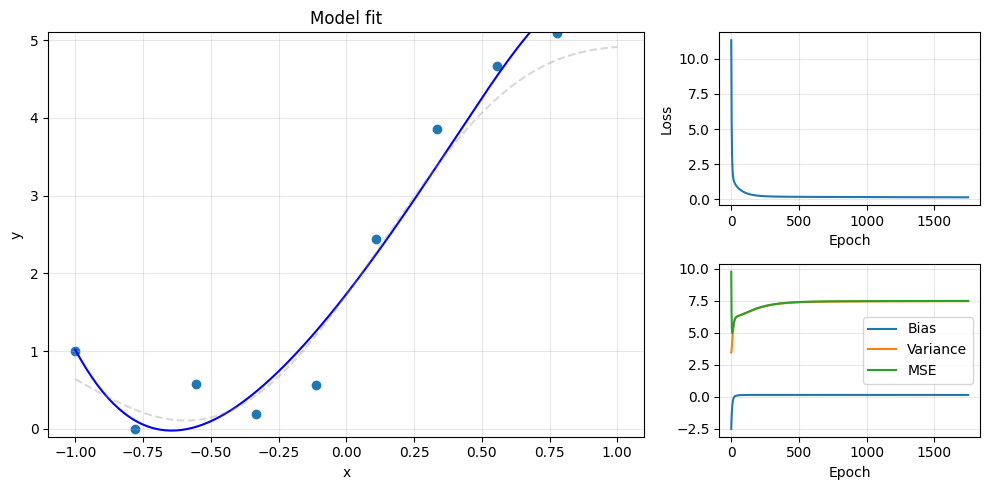

Training:  88%|████████▊ | 1751/2000 [00:14<00:01, 131.60it/s]

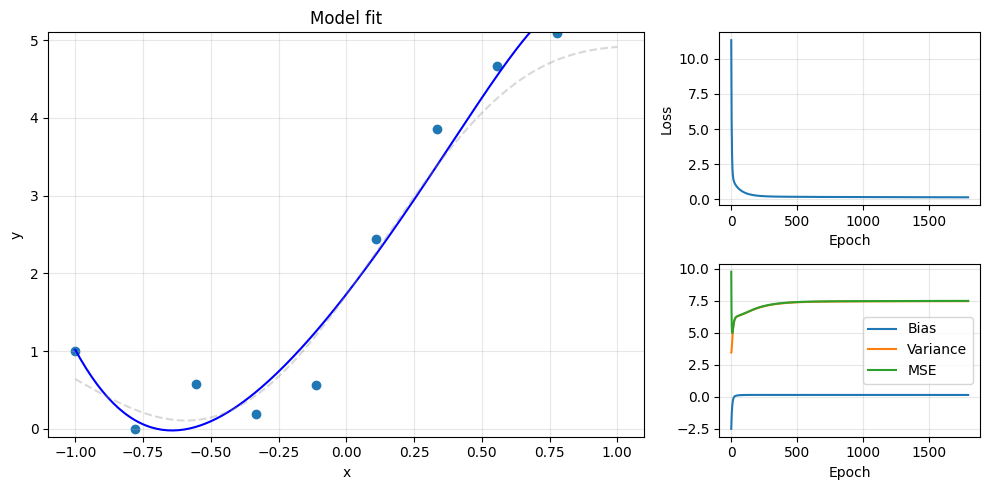

Training:  90%|█████████ | 1801/2000 [00:15<00:02, 96.26it/s] 

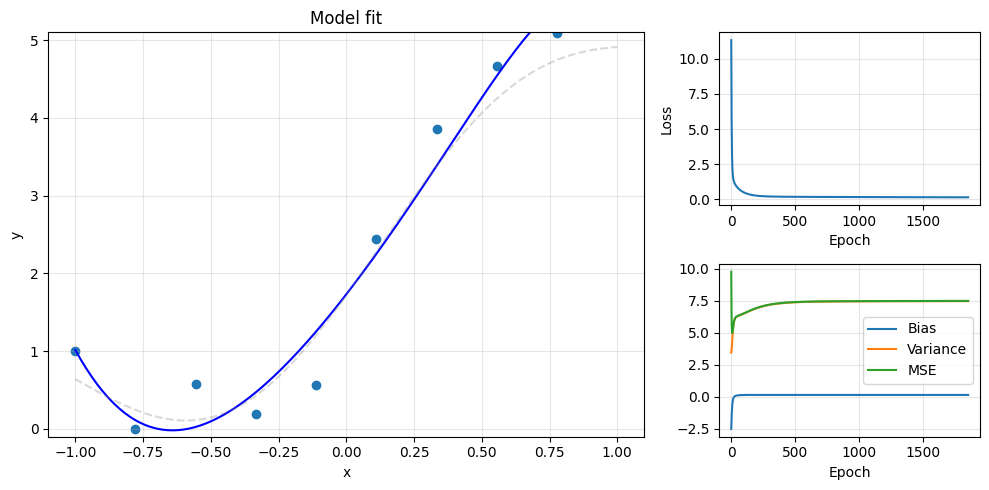

Training:  93%|█████████▎| 1851/2000 [00:16<00:01, 107.07it/s]

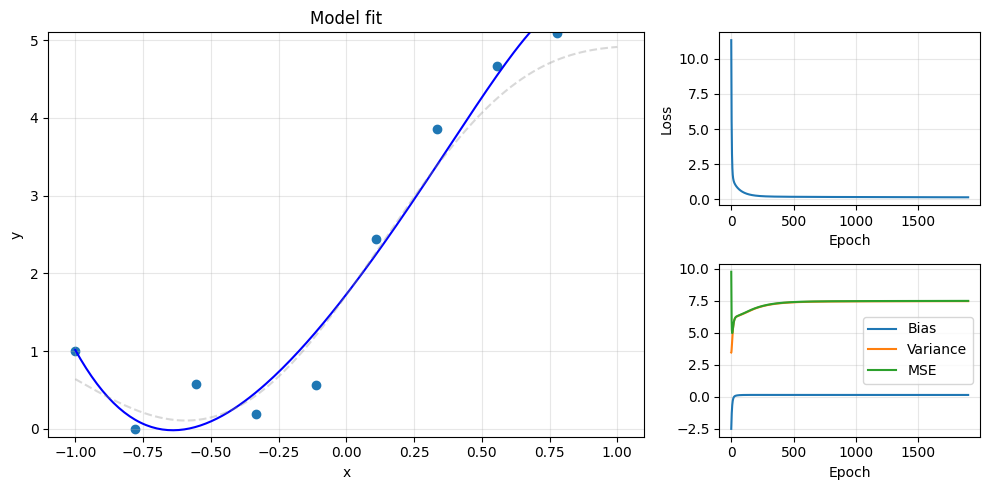

Training:  95%|█████████▌| 1901/2000 [00:16<00:00, 116.56it/s]

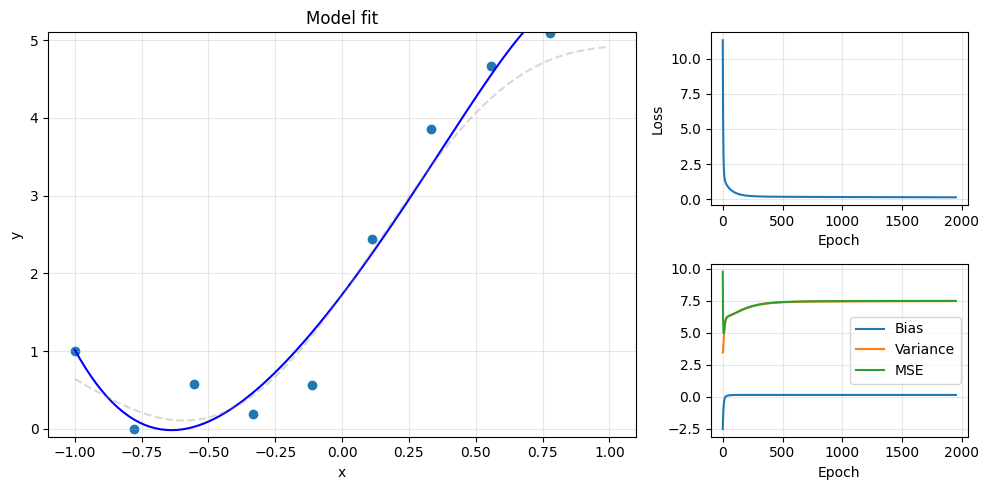

Training:  98%|█████████▊| 1951/2000 [00:16<00:00, 122.61it/s]

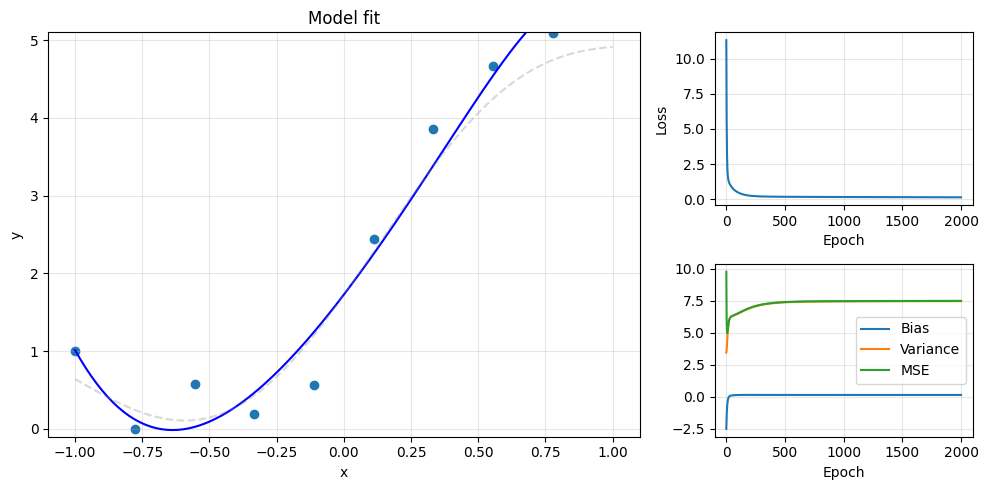

In [27]:
print("Training high-degree polynomial WITHOUT regularisation:")
model_noreg = PolynomialModel(degree=8)
_ = train_polynomial(model_noreg, X_tensor, y_tensor, epochs=2000, lambda_l2=0.0, plot_freq=250)

**Observation:** Without regularisation, the high-degree polynomial usually overfits - it passes through the noisy points but oscillates wildly. But for this particular dataset, the results are similar.

---

## Part 2: Early Stopping on MNIST

Another way to prevent overfitting is to stop training when validation loss stops improving. I trained a neural network on MNIST and monitored both training and validation loss.

In [28]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())

print(f"Training data: {training_data.data.size()}")
print(f"Test data: {test_data.data.size()}")

Training data: torch.Size([60000, 28, 28])
Test data: torch.Size([10000, 28, 28])


In [29]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)

In [30]:
def l2_regularization(model, lambda_l2):
    #computes sum of squared weights
    return lambda_l2 * sum(torch.sum(p ** 2) for p in model.parameters())

def train_with_early_stopping(model, X, y, X_val, y_val, epochs=100, batch_size=32, lr=0.01,
                               lambda_l2=0.0, patience=10):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_hist, val_loss_hist = [], []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        #shuffle data each epoch
        perm = torch.randperm(X.size(0))
        X, y = X[perm], y[perm]

        model.train()
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            if lambda_l2 > 0:
                loss = loss + l2_regularization(model, lambda_l2)

            loss.backward()
            optimizer.step()

        #compute epoch losses
        model.eval()
        with torch.no_grad():
            train_loss = loss_fn(model(X), y).item()
            val_loss = loss_fn(model(X_val), y_val).item()

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        #early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
                break

    return train_loss_hist, val_loss_hist

In [31]:
model = MNISTClassifier()

X_train = training_data.data.float()
y_train = training_data.targets
X_val = test_data.data.float()
y_val = test_data.targets

train_hist, val_hist = train_with_early_stopping(
    model, X_train, y_train, X_val, y_val,
    epochs=100, batch_size=64, lr=0.01, lambda_l2=0.0001, patience=10
)

Epoch   0 | Train Loss: 835965440.0000 | Val Loss: 886305088.0000
Epoch  10 | Train Loss: 86458184.0000 | Val Loss: 147970080.0000
Epoch  20 | Train Loss: 46433400.0000 | Val Loss: 122727248.0000
Epoch  30 | Train Loss: 21280376.0000 | Val Loss: 117920784.0000
Early stopping at epoch 33 (no improvement for 10 epochs)


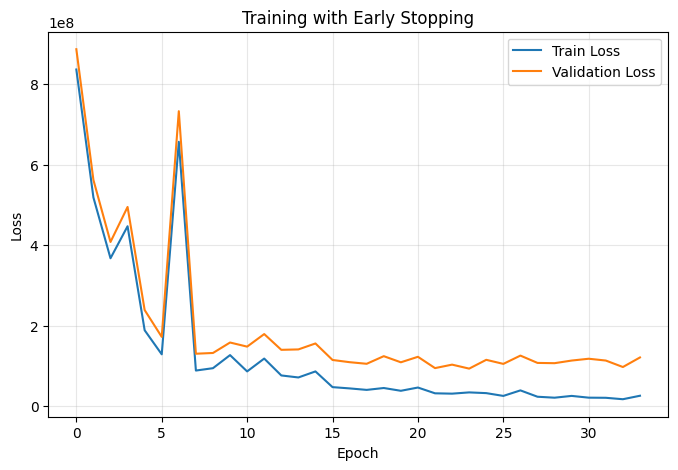

In [32]:
#plotting training curves
plt.figure(figsize=(8, 5))
plt.plot(train_hist, label='Train Loss')
plt.plot(val_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training with Early Stopping')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [33]:
#final accuracy
model.eval()
with torch.no_grad():
    train_acc = (model(X_train).argmax(dim=1) == y_train).float().mean().item()
    val_acc = (model(X_val).argmax(dim=1) == y_val).float().mean().item()

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

Training Accuracy: 98.11%
Validation Accuracy: 95.79%


---

## Part 3: L1 Regularisation (LASSO)

L1 regularisation penalises the absolute value of weights instead of their squares. This encourages sparsity - many weights become exactly zero. This is useful for feature selection.

I'm testing this on synthetic data where only 4 out of 20 features actually matter.

In [38]:
#synthetic data where only first 4 features have non-zero true weights
torch.manual_seed(42)

n_samples, n_features = 100, 20
X = torch.randn(n_samples, n_features)

#true weights: only first 4 are non-zero
true_weights = torch.tensor([2.0, -1.5, 1.0, -0.8] + [0.0] * 16)
y = X @ true_weights + torch.randn(n_samples) * 0.5

print(f"True weights: {true_weights[:6].tolist()}... (rest are 0)")

True weights: [2.0, -1.5, 1.0, -0.800000011920929, 0.0, 0.0]... (rest are 0)


In [39]:
class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):
        return self.linear(x)

def train_lasso(model, X, y, lambda_l1, epochs=250, lr=0.01):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    weights_history = []

    for epoch in range(epochs):
        model.zero_grad()
        y_pred = model(X)
        loss = mse_loss(y_pred, y.view(-1, 1))

        #L1 regularisation: sum of absolute values of weights
        if lambda_l1 > 0:
            l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
            loss = loss + lambda_l1 * l1_penalty

        loss.backward()
        optimizer.step()
        weights_history.append(model.linear.weight.detach().numpy().flatten().copy())

    return np.array(weights_history)

In [40]:
#comparing with and without L1 regularisation
model_no_l1 = LinearModel(n_features)
model_with_l1 = LinearModel(n_features)

weights_no_l1 = train_lasso(model_no_l1, X, y, lambda_l1=0.0)
weights_with_l1 = train_lasso(model_with_l1, X, y, lambda_l1=1)

print("Final weights WITHOUT L1:")
print(f"  First 6: {weights_no_l1[-1][:6].round(3)}")
print(f"  Non-zero (>0.001): {np.sum(np.abs(weights_no_l1[-1]) > 0.001)}")

print("\nFinal weights WITH L1:")
print(f"  First 6: {weights_with_l1[-1][:6].round(3)}")
print(f"  Non-zero (>0.001): {np.sum(np.abs(weights_with_l1[-1]) > 0.001)}")

print(f"\nTrue weights: {true_weights[:6].tolist()}")

Final weights WITHOUT L1:
  First 6: [ 1.867 -1.405  0.889 -0.739  0.062 -0.015]
  Non-zero (>0.001): 20

Final weights WITH L1:
  First 6: [ 1.30e+00 -8.59e-01  3.38e-01 -3.52e-01  1.00e-03  1.10e-02]
  Non-zero (>0.001): 18

True weights: [2.0, -1.5, 1.0, -0.800000011920929, 0.0, 0.0]


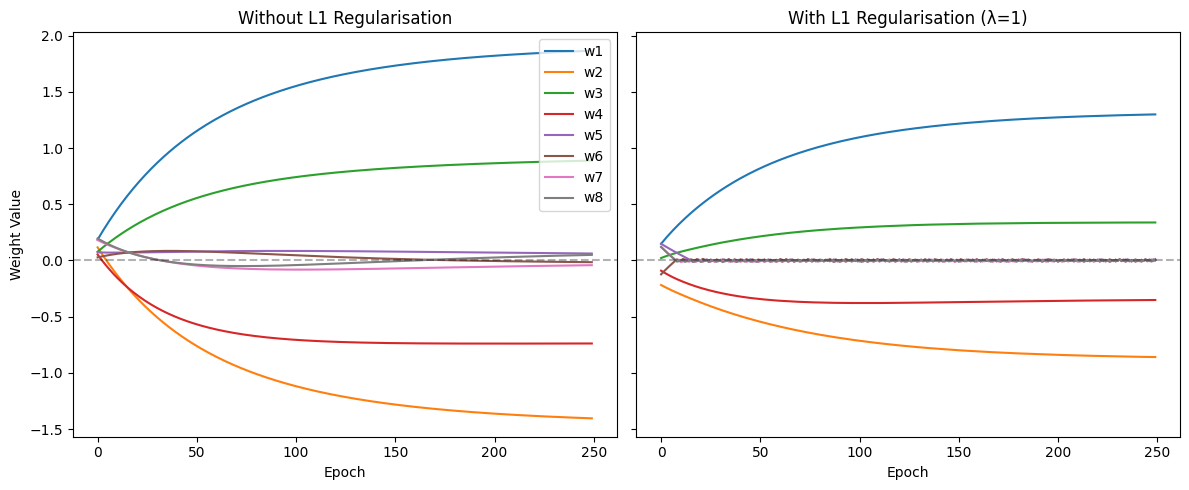

In [41]:
#visualizing how weights evolve during training
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
epochs = np.arange(weights_no_l1.shape[0])

for i in range(8):
    color = f'C{i}'
    axes[0].plot(epochs, weights_no_l1[:, i], color=color, label=f'w{i+1}')
    axes[1].plot(epochs, weights_with_l1[:, i], color=color)

axes[0].set_title('Without L1 Regularisation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Weight Value')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].legend(loc='upper right')

axes[1].set_title('With L1 Regularisation (λ=1)')
axes[1].set_xlabel('Epoch')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

- **L2 regularisation** penalises large weights, keeping the model smoother and reducing variance
- **Early stopping** prevents overfitting by stopping when validation loss stops improving
- **L1 regularisation** encourages sparsity - irrelevant features get pushed to zero, which is useful for feature selection

In practice, these techniques are often combined. For example, Adam optimizer with weight decay (L2) plus early stopping is a common setup.